In [3]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import regex as re
from lxml import etree as et
from itertools import repeat
import csv
import random
import time
from tqdm import tqdm_notebook # tqdm_notebook es una herramienta que permite mostrar barra de progreso al trabajar con bucles grandes
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import math
from ast import literal_eval
import Funciones

In [92]:
from importlib import reload
import Funciones
reload(Funciones)

<module 'Funciones' from '/Users/jaimeinchaurraga/Documents/GitHub/ONLINE_DS_THEBRIDGE_jaimeinchaurraga/EDA_Entrega/Funciones.py'>

## IMPORTANTE
DEBIDO AL PESO DE LOS ARCHIVOS CSV, SÓLO SE HA MANTENIDO UNA VERSIÓN CON TODOS LOS CAMBIOS. SI SE EJECUTAN LAS CELDAS SE PUEDEN VER CAMBIOS YA QUE 
AL FINAL DEL TODO TRABAJO SE QUITÓ LAS COLUMNAS DE 'REVIEWS' Y 'SUMMARY' PARA REDUCIR MÁS EL PESO

TENGO GUARDADAS TODAS LAS VERSIONES DE LOS CSVs A LO LARGO DE TODO EL PROCESO POR SI SE REQUIEREN (WEB SCRAPING, LIMPIEZA, ANÁLISIS, ETC)

## **ANÁLISIS UNIVARIANTE DE LAS VARIABLES PRINCIPALES**

En este fichero llevaré a cabo un análisis detallado de las variables principales de forma individualizada, tanto categóricas como numéricas, de esa manera obtendré información relevante 
para cuando posteriormente tenga que cruzar variables para responder a las preguntas


### ÍNDICE
- [Primeros Pasos](#Primeros-Pasos)
- [Variables Categoricas Cardinalidad y Frecuencias](#Variables-Categoricas-Cardinalidad-y-Frecuencias)
- [Variables Categoricas Conclusiones Finales](#Variables-Categoricas-Conclusiones-Finales)
- [Variables Numericas Medidas Posicionales](#Variables-Numericas-Medidas-Posicionales)
- [Variables Numericas Desviacion](#Variables-Numericas-Desviacion)
- [Variables Numericas Conclusiones finales](#Variables-Numericas-Conclusiones-finales)
- [Tratamiento de Outliers](#Tratamiento-de-Outliers)
- [Filtrados y manipulaciones del Data Frame](#Filtrados-y-manipulaciones-del-Data-Frame)


- He tenido que quitar las tildes y caracteres expeciales para evitar problemas de formato con las anclas

<a id="Primeros-Pasos"></a>

<a id="Primeros-Pasos"></a>
## Primeros Pasos

##### A partir del dataframe actualizado, elaboro una tabla con la información más relevante de cada variable, la cual será útil a la hora de realizar el análisis


| Variable           | Dtype     | Clasificación         | Descripción                                  | Comentarios                                       |
|--------------------|-----------|-----------------------|----------------------------------------------|---------------------------------------------------|
| Title              | object    | Categórica nominal    | Nombre del juego                            |    Variable core                                             |
| Release Date       | datetime64| Fecha                 |    Fecha de lanzamiento  |                                                 |
| Team               | object    | Categórica nominal    | Equipo de desarrollo              |                                                 |
| Avg. Rating        | float64   | Numérica continua     | Calificación promedio del juego             |     Variable core                                            |
| Times Listed       | Int64     | Numérica discreta     | Veces que aparece en listas de juegos creadas por usuarios       |                                                 |
| Number of Reviews  | Int64     | Numérica discreta     | Número de reseñas del juego                 |                                                 | |
| Genres             | object    | Categórica nominal    | Géneros del juego                           |                                                 |
| Summary            | object    | Categórica nominal    | Resumen del juego                           |                                                 |
| Reviews            | object    | Categórica nominal    | Reseñas del juego                           |                                                 |
| Platforms          | object    | Categórica nominal    | Plataformas en las que se juega             |                                                 |
| Plays              | Int64     | Numérica discreta     | Número de partidas jugadas                  |      Variable core                                           |
| Playing            | Int64     | Numérica discreta     | Número de partidas en curso                 |                                                 |
| Backlogs           | Int64     | Numérica discreta     | Número de juegos pendientes de jugar        |                                                 |
| Wishlist           | Int64     | Numérica discreta     | Número de juegos en la lista de deseos      |                                                 |


In [93]:
# Creo un dataframe a partir del último CSV que creé, que contiene los datos limpios
df = pd.read_csv('data/backloggd_dataset_limpio_dos.csv')

In [94]:
# Por alguna razón que desconozco, la variable de 'Release Date' pierde su formato de fecha cuando lo importo, por ello lo vuelvo a transformar antes de analizar los datos
# Convertir la columna 'Release Date' a formato de fecha
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')

In [96]:
# Creo un identificador de videjuegos a través de la columna 'GameID' --> esto me ayudará en posteriores tratmientos e identificación de juegos en listas 'explotadas'
df['GameID'] = df.index

# Ahora restablece el índice para hacerlo secuencial y comenzar en 0
df.reset_index(drop=True, inplace=True)


In [97]:
# Realizo una comprobación rápida de su estructura para comprobar que está correcto
df.head()

,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist,GameID
0,Elden Ring,2022-02-25,"['FromSoftware', 'Bandai Namco Entertainment']",4.5,6200,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","['👍', 'A good effort from konami, but at the e...","['Windows PC, PlayStation 4, Xbox One, PlaySta...",33000,5200,8700,7300,0
1,The Legend of Zelda: Tears of the Kingdom,2023-05-12,"['Nintendo', 'Nintendo EPD Production Group No...",4.5,4200,"['Adventure', 'RPG']",The Legend of Zelda: Tears of the Kingdom is t...,['Legend of Zelda: Tears of the Kingdom is a v...,['Nintendo Switch'],16000,6500,6300,6900,1
2,The Legend of Zelda: Breath of the Wild,2017-03-03,"['Nintendo EPD Production Group No. 3', 'Ninte...",4.4,6600,"['Adventure', 'Puzzle', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,"['👍', 'very nice game, my first Legend of Zeld...","['Wii U, Nintendo Switch']",48000,3700,7600,3900,2
3,Hades,2018-12-07,['Supergiant Games'],4.3,4200,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,"[""I enjoyed it quite a bit, but with games lik...","['Windows PC, Mac, PlayStation 4, Xbox One, Pl...",35000,4400,10000,5300,3
4,Hollow Knight,2017-02-24,['Team Cherry'],4.4,4600,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"['This game is perfect, I immediately fell in ...","['Windows PC, Mac, Wii U, Linux, Nintendo Swit...",35000,3600,13000,3600,4


In [98]:
# Se puede observar que está formado por las variables correctas. También con el número de valores esperados y sin nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30208 entries, 0 to 30207
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Title         30208 non-null  object        
 1   Release Date  30208 non-null  datetime64[ns]
 2   Team          30208 non-null  object        
 3   Avg. Rating   30208 non-null  float64       
 4   Times Listed  30208 non-null  int64         
 5   Genres        30208 non-null  object        
 6   Summary       30208 non-null  object        
 7   Reviews       30208 non-null  object        
 8   Platforms     30208 non-null  object        
 9   Plays         30208 non-null  int64         
 10  Playing       30208 non-null  int64         
 11  Backlogs      30208 non-null  int64         
 12  Wishlist      30208 non-null  int64         
 13  GameID        30208 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(6)
memory usage: 3.2+ MB


In [99]:
# Obtengo la cardinalidad de cada varibale, ya que me ayuda a formarme la idea a grandes rasgos de la estrctura del dataset
# Una variable con cardinalidad baja tiene un número relativamente pequeño de valores únicos
# Una variable con alta cardinalidad tiene un gran número de valores únicos
# Como expiqué al final del fichero 'Limpieza_base_dataset', 'Title' no tiene la cardinalidad al 100% porque hay juegos diferentes que tienen el mismo nombre


# Cálculo de la cardinalidad
cardinalidad_global = df.nunique()
porcentaje_cardinalidad_global = (df.nunique() / len(df)) * 100
df_cardinalidad = pd.DataFrame({'Card': cardinalidad_global, '%_Card': porcentaje_cardinalidad_global})
df_cardinalidad

,Card,%_Card
Title,29487,97.613215
Release Date,8392,27.780720
Team,14992,49.629237
Avg. Rating,48,0.158898
Times Listed,877,2.903204
Genres,1575,5.213851
Summary,30208,100.000000
Reviews,15468,51.204979
Platforms,2780,9.202860
Plays,1098,3.634799


In [100]:
# Agrupo en dos listas las variables según su tipo, por si posteriormente tengo que trabajar con ellas de forma conjunta

# Lista de nombres de columnas categóricas
columnas_categoricas = ['Title', 'Team', 'Genres', 'Summary', 'Reviews', 'Platforms']

# Lista de nombres de columnas categóricas sin algunas columnas --> son las más importantes
columnas_categoricas_core = ['Title', 'Team', 'Genres', 'Platforms']

# Lista de nombres de columnas numéricas
columnas_numericas = ['Avg. Rating', 'Times Listed', 'Plays', 'Playing', 'Backlogs', 'Wishlist']

# La columna 'Release Date' de tipo datetime64[ns] se deja fuera de estas listas

##### **DECRIPCIÓN BÁSICA VARIABLES NUMÉRICAS**

In [101]:
df.describe()

,Release Date,Avg. Rating,Times Listed,Plays,Playing,Backlogs,Wishlist,GameID
count,30208,30208.000000,30208.000000,30208.000000,30208.000000,30208.000000,30208.000000,30208.000000
mean,2011-11-12 06:55:52.118643968,3.097007,73.611527,525.286679,16.726794,142.501126,69.293200,15103.500000
min,1969-07-01 00:00:00,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2005-09-13 00:00:00,3.100000,1.000000,1.000000,0.000000,1.000000,0.000000,7551.750000
50%,2015-07-23 00:00:00,3.100000,4.000000,9.000000,0.000000,4.000000,2.000000,15103.500000
75%,2020-01-09 00:00:00,3.300000,34.000000,117.000000,2.000000,43.000000,21.000000,22655.250000
max,2029-12-01 00:00:00,5.000000,6600.000000,53000.000000,6500.000000,13000.000000,7300.000000,30207.000000
std,NaN,0.531258,260.565944,2238.989865,119.980305,563.642680,294.548148,8720.442802


In [102]:
# Obtengo la media de todas las variables numéricas
df.describe().loc["mean"]

Release Date    2011-11-12 06:55:52.118643968
Avg. Rating                          3.097007
Times Listed                        73.611527
Plays                              525.286679
Playing                             16.726794
Backlogs                           142.501126
Wishlist                              69.2932
GameID                                15103.5
Name: mean, dtype: object

In [103]:
# Obtengo la mediana de todas las variables numéricas
df.describe().loc["50%"]

Release Date    2015-07-23 00:00:00
Avg. Rating                     3.1
Times Listed                    4.0
Plays                           9.0
Playing                         0.0
Backlogs                        4.0
Wishlist                        2.0
GameID                      15103.5
Name: 50%, dtype: object

In [102]:
# Obtengo la mediana de todas las variables numéricas
# Lo que puedo ir observando es que hay una gran dispersión de datos
df.describe().loc["max"]

Release Date    2029-12-01 00:00:00
Avg. Rating                     5.0
Times Listed                 6600.0
Plays                       53000.0
Playing                      6500.0
Backlogs                    13000.0
Wishlist                     7300.0
Name: max, dtype: object

<a id="Cardinalidad-Frecuencias"></a>

<a id="Variables-Categoricas-Cardinalidad-y-Frecuencias"></a>
## Variables Categoricas: Cardinalidad y Frecuencias

In [104]:
# A través del siguiente código puedo analizar la composición de los valores de las columnas categóricas

# Listas para almacenar los resultados
columnas = []
valores_totales = []
valores_unicos = []
porcentajes_unicos = []

# Calculando los valores para cada columna categórica
for columna in columnas_categoricas:
    total_valores = df[columna].count()
    unicos_valores = df[columna].nunique()
    porcentaje_unicos = (unicos_valores / total_valores) * 100

    # Añadiendo los resultados a las listas
    columnas.append(columna)
    valores_totales.append(total_valores)
    valores_unicos.append(unicos_valores)
    porcentajes_unicos.append(porcentaje_unicos)

# Creando el DataFrame a partir de las listas
resumen_categoricas = pd.DataFrame({
    'Columna': columnas,
    'Valores Totales': valores_totales,
    'Valores Únicos': valores_unicos,
    'Porcentaje Únicos': porcentajes_unicos
})

# Mostrando los resultados
resumen_categoricas

# mmmmmmhh... algo no me termina de cuadrar en la mayoría de las cardinalidades de las columnas... tendré que investigarlo con lupa :) 

,Columna,Valores Totales,Valores Únicos,Porcentaje Únicos
0,Title,30208,29487,97.613215
1,Team,30208,14992,49.629237
2,Genres,30208,1575,5.213851
3,Summary,30208,30208,100.000000
4,Reviews,30208,15468,51.204979
5,Platforms,30208,2780,9.202860


In [14]:
'''
# Detallo el por qué entonces la cardinalidad no es del 100% en la mayoría de las columnas:

# - Title: aunque es muy alta no llega al 100% porque hay juegos diferentes que tienen el mismo nombre
# - Team: Realmente no hay 14992 equipos diferentes pero en muchas ocasiones se tratan de colaboraciones de sub-compañías o compañías diferentes, por lo que el dataframe toma cada una de ellas como un valor distinto
# - Genres: Pasa algo parecido con Team, un juego puede estar clasificado con diferentes géneros (en ocasiones 3 o más) por lo que Python interpreta que cada combinación de esos juegos es un genero por sí mismo
# - Lo más seguro es que para los casos anteriores, posteriormente tenga que 'explotar' esas listas para mostrar el número real de esas varibales y poder hacer análisis específicos
# - Summary: la cardinalidad es el 100%, es el mejor indicativo para demostrar que no hay filas duplicadas, ya que las descripciones sí que son únicas por videjuego
# - Reviews: Podría plantearse la pregunta de ¿Reviews no debería ser 100% cardinal, como en summary dado que cada valoración es única? Sí, pero en este caso hay una gran cantidad de juegos que no tienen comentarios y todos esos casos están formados
#por un '[]', es decir, una lista vacía. Ese es el único valor que se repite (lo comprobé en la limpieza de datos)
# - 'Platforms': la misma casuística que 'Team y 'Genres'
'''

"\n# Detallo el por qué entonces la cardinalidad no es del 100% en la mayoría de las columnas:\n\n# - Title: aunque es muy alta no llega al 100% porque hay juegos diferentes que tienen el mismo nombre\n# - Team: Realmente no hay 14992 equipos diferentes pero en muchas ocasiones se tratan de colaboraciones de sub-compañías o compañías diferentes, por lo que el dataframe toma cada una de ellas como un valor distinto\n# - Genres: Pasa algo parecido con Team, un juego puede estar clasificado con diferentes géneros (en ocasiones 3 o más) por lo que Python interpreta que cada combinación de esos juegos es un genero por sí mismo\n# - Lo más seguro es que para los casos anteriores, posteriormente tenga que 'explotar' esas listas para mostrar el número real de esas varibales y poder hacer análisis específicos\n# - Summary: la cardinalidad es el 100%, es el mejor indicativo para demostrar que no hay filas duplicadas, ya que las descripciones sí que son únicas por videjuego\n# - Reviews: Podría p

In [125]:
# FRECUENCIA ABSOLUTA EN CATEGÓRICAS CORE
# Excluyo las variables 'Summary' y 'Reviews' de la iteración porque no me resultan útiles y ensucian los resultados
# Des comentat para ver los resultados (ocupan mucho espacio)
'''
# Itero solo a través de las columnas restantes y obtengo los valores absolutos
for catego in columnas_categoricas_core:
    print(f"Para {catego}")
    print(df[catego].value_counts())
    print("\n" * 2)
'''

'\n# Itero solo a través de las columnas restantes y obtengo los valores absolutos\nfor catego in columnas_categoricas_core:\n    print(f"Para {catego}")\n    print(df[catego].value_counts())\n    print("\n" * 2)\n'

In [ ]:
'''
# EXPLOTAR LISTAS EN VARIABLES CATEGÓRICAS
# A continuación voy a trabajar en solucionar el problema que comentaba en la celda anterior que afecta a ['Team', 'Genres', 'Platforms'] donde no se contabilizan 
# correctamente ciertos valores. Esto ocurre cuando un videjuego tiene más de un valor etiquetado a una variable por ejemplo, en 'Genres' hay 1216 valores para ['Adventure', 'Indie'] 1132 para ['Indie'] y 1296 para ['Adventure']
# quiero trabajar correctamente con las modas y frecuentas tanto relativas como absolutas. Pra ello, siguiendo el ejemplo anterior, si un juego está clasificado como ['Adventure', 'Indie'] se realizará un +1 tanto en ['Indie'] como en ['Adventure']
# tal vez, mantener los valores como están tengan algún tipo de beneficio que ahora mismo no soy capaz de ver. por ello dejaré impreso la anterior versión, pero me veo forzado a realizar el cambio para obtener insights y mejoras en la visualización
'''

In [105]:
# EXPLOTAR LISTAS EN VARIABLES CATEGÓRICAS BUENA!
# En esta sección, creo una lógica que recorrerá los valores de las columnas, evaluará si son cadenas de texto que representan listas y en ese caso cambiarlas a objeto listas de python
# Esto es necesario para posteriormente poder aplicar aplicar el método explode que separa los valores de una lista a filas independientes
# Itero sobre las columnas que tienen la problemática
for col in ['Team', 'Genres', 'Platforms']:
    def eval_lists(val):  # la función toma un argumento val, que representa un valor individual dentro de la columna actual (col) sobre la que está iterando
        from ast import literal_eval

        if val == "Unknown":  # en el caso que aparezca 'Unknown' se cambia a lista vacía, así no da problemas y se mantiene la lógica que he aplicado a otras columnas cuando faltaban datos
            return []
        try: # Convertir la cadena a una lista de Python
            evaluated_val = literal_eval(val) if isinstance(val, str) else val #se evalúa el valor para ver si es una cadena (una falsa lista) y en ese caso se convierte a formato lista real. si no es una cadena no se hace nada
            if col == 'Platforms': # Tratamiento especial para la columna 'Platforms' PORQUE TIENE FORMATO RARO
                # Dividir cada elemento de la lista por comas y aplanar la lista resultante
                return [platform for sublist in evaluated_val for platform in sublist.split(', ')] if evaluated_val else []
            else:
                return evaluated_val
        except ValueError:
            print(f"Error al evaluar: {val}")
            return []

    df[col] = df[col].apply(eval_lists)



In [80]:
# EXPLOTAR LISTAS EN VARIABLES CATEGÓRICAS V1 (LA MANTENGO POR SI ACASO)
# En esta sección, creo una lógica que recorrerá los valores de las columnas, evaluará si son cadenas de texto que representan listas y en ese caso cambiarlas a objeto listas de python
# Esto es necesario para posteriormente poder aplicar aplicar el método explode que separa los valores de una lista a filas independientes
'''
from ast import literal_eval

# Itero sobre las columnas que tienen la problemática
for col in ['Team', 'Genres', 'Platforms']:
    def eval_lists(val): #  la función toma un argumento val, que representa un valor individual dentro de la columna actual (col) sobre la que está iterando
        if val == "Unknown": # en el caso que aparezca 'Unknown' se cambia a lista vacía, así no da problemas y se mantiene la lógica que he aplicado a otras columnas cuando faltaban datos
            return []
        try:
            # Convertir la cadena a una lista de Python
            evaluated_val = ast.literal_eval(val) if isinstance(val, str) else val # se evalúa el valor para ver si es una cadena (una falsa lista) y en ese caso se convierte a formato lista real. si no es una cadena no se hace nada
            
            # Tratamiento especial para la columna 'Platforms'
            if col == 'Platforms': # los valores en esta columna tienen un formato raro, por ello deboa aplicar un tratamiento especial
                # Si la lista tiene elementos, dividir el primer elemento en varios, si no, devolver la lista vacía
                return evaluated_val[0].split(', ') if evaluated_val else [] # en este caso ya es una lista convertida. si la lista no está vacía, toma el primer elemento y lo divide en varios elementos con el método 'split' a partir de las comas
            else:
                # Para 'Team' y 'Genres', devolver la lista evaluada
                return evaluated_val
        except ValueError:
            print(f"Error al evaluar: {val}")
            return []

    df[col] = df[col].apply(eval_lists)

'''


In [ ]:
'''
MOTIVO POR EL QUE NO PODÍA EXPLOTAR CORRECTAMENTE LA COLUMNA "PLATFORMS":
El formato de los valores en la columna 'Platforms' muestra que cada entrada es una cadena que representa una lista, pero dentro de esta "lista", las plataformas individuales no están separadas por comillas. 
Por ejemplo, ['Windows PC, PlayStation 4, Xbox One'] en lugar de ['Windows PC', 'PlayStation 4', 'Xbox One'].

Este es el motivo por el cual el método explode no estaba funcionando correctamente. 
La función ast.literal_eval estaba interpretando cada valor como una lista con un solo elemento (que es una cadena larga con todas las plataformas), en lugar de una lista con elementos separados.
Para solucionar este problema, necesitas modificar la función eval_lists para que divida correctamente las plataformas en elementos separados de una lista
'''

In [106]:
# Aquí llevo la explotación de cada lista para que se separen en filas individuales cada uno de los valores en las tres columnas, lo que me ayudará a analizar correctamente las modas y frecuencias 
# Hay que tener en cuenta que realmente estoy creando nuevos dataframes por cada variable explotada, o puedo mantenerlo en el mismo ya que cada valor explotado crea una nueva fila y por lo tanto
# rompería por completo mi dataset. A la hora de analizar y visualizar, tendré que tnerlo en cuenta

# Exploto la columna 'Genres'
df_exploded_genres = df.explode('Genres')
#frecuencias_genres = df_exploded_genres['Genres'].value_counts()
#moda_genres = df_exploded_genres['Genres'].mode()

# Exploto la columna 'Team'
df_exploded_team = df.explode('Team')
#frecuencias_team = df_exploded_team['Team'].value_counts()
#moda_team = df_exploded_team['Team'].mode()

# Exploto la columna 'Platforms'
df_exploded_platform = df.explode('Platforms')
#frecuencias_platform = df_exploded_platform['Platforms'].value_counts()
#moda_platform = df_exploded_platform['Platforms'].mode()



In [126]:
# FRECUENCIA ABSOLUTA EN CATEGÓRICAS CORE EXPLOTADAS
# Ahora puedo ver las frecuencias absolutas de las columnas categóricas que me interesan, es decir

# Crear un diccionario con los DataFrames explotados y sus nombres de columnas relevantes
# De esta manera, es sencillo, poder iterar sobre las columnas que ya están explotadas, donde la clave el es el nombre de la columna y el valor es el dataframe ya explotado 
dataframes_exploded = {
    'Genres': df_exploded_genres,
    'Team': df_exploded_team,
    'Platforms': df_exploded_platform
}

# Configuración para no limitar la cantidad de filas al imprimir
#pd.set_option('display.max_rows', None)

# Iterar a través del diccionario y aplicar value_counts() a cada DataFrame
for col, df_exploded in dataframes_exploded.items(): # 'col' pilla la clave y 'df_exploted' el valor explotado dentro del diccionarios creado llamado 'dataframes_exploted'
    print(f"Para {col}")
    print(df_exploded[col].value_counts())
    print("\n" * 2)


Para Genres
Genres
Adventure              10895
Indie                   9162
RPG                     5067
Simulator               4328
Strategy                4286
Shooter                 4182
Puzzle                  3909
Platform                3442
Arcade                  3032
Sport                   2020
Racing                  1434
Visual Novel            1427
Fighting                1371
Brawler                 1167
Point-and-Click          887
Turn Based Strategy      815
Tactical                 657
Music                    627
Card & Board Game        605
Real Time Strategy       572
Quiz/Trivia              266
Pinball                   86
MOBA                      23
Name: count, dtype: int64



Para Team
Team
Nintendo                                                 769
Sega                                                     449
Konami                                                   443
Capcom                                                   420
Electronic Arts           

In [108]:
# CARDINALIDAD VARIABLES CATEGÓRICAS + VARIABLES CATEGÓRICAS EXPLOTADAS
# Aquí se puede observar 

# Calcula la cardinalidad para las columnas que no son listas
columnas_no_lista = [col for col in df.columns if col not in ['Genres', 'Team', 'Platforms']]
cardinalidad_global = df[columnas_no_lista].nunique()
porcentaje_cardinalidad_global = (cardinalidad_global / len(df)) * 100
df_cardinalidad = pd.DataFrame({'Card': cardinalidad_global, '%_Card': porcentaje_cardinalidad_global})

# Actualiza la cardinalidad para las columnas explotadas
df_cardinalidad.loc['Genres'] = [df_exploded_genres['Genres'].nunique(), (df_exploded_genres['Genres'].nunique() / len(df_exploded_genres)) * 100]
df_cardinalidad.loc['Team'] = [df_exploded_team['Team'].nunique(), (df_exploded_team['Team'].nunique() / len(df_exploded_team)) * 100]
df_cardinalidad.loc['Platforms'] = [df_exploded_platform['Platforms'].nunique(), (df_exploded_platform['Platforms'].nunique() / len(df_exploded_platform)) * 100]

# Mostrar el DataFrame de cardinalidad actualizado
df_cardinalidad


,Card,%_Card
Title,29487.0,97.613215
Release Date,8392.0,27.780720
Avg. Rating,48.0,0.158898
Times Listed,877.0,2.903204
Summary,30208.0,100.000000
Reviews,15468.0,51.204979
Plays,1098.0,3.634799
Playing,511.0,1.691605
Backlogs,965.0,3.194518
Wishlist,857.0,2.836997


In [ ]:
'''
Como se puede observar, comparado con la primera vez que calculé la cardinalidad antes de explotar ciertas variables, se ha reducido mucho el número de valores únicos,
por ejemplo en 'genres' que ahora sólo tiene 23 géneros distintos
'''

In [17]:
# FRECUENCIA ABSOLUTA EN CATEGÓRICAS CORE EXPLOTADAS V2 (versión alternativa que no utilizaré mucho, es sólo para tener otra perspectiva)
# He creado una nueva versión para visualizar las frecuencias absolutas, ya que aparte de informativo, se sirve para confirmar que las gráficas están bien
# - He realizado una modificación para que a la hora de visualizar los datos, se puedan comprimir todos aquellos valores que sólo tienen asociado un videjuego
# para ello, todos aquellos valores (que son muchos) que sólo tienen asocidados un videojuego entran en un nuevo valor que los aglutina todos en cada una de las columnas llamado 'Otros'

# Re-utilizo el diccionario con los dataFrames explotados 
dataframes_exploded = {
    'Genres': df_exploded_genres,
    'Team': df_exploded_team,
    'Platforms': df_exploded_platform
}

# Incluyo 'Title' directamente desde el DataFrame original --> Recuerdo que esta columna no fue explotada porque no aplicaba en su caso
dataframes_exploded['Title'] = df[['Title']]

# Crear un nuevo diccionario para almacenar todas las frecuencias absolutas
frecuencias_absolutas_categoricas_core = {}

# Iterar a través del diccionario y calcular value_counts() a cada DataFrame
for col, df_col in dataframes_exploded.items():
    # Aplicar value_counts a la columna correspondiente del DataFrame
    value_counts = df_col[col].value_counts()

    # Agrupar valores con solo un juego bajo 'Otros'
    otros = value_counts[value_counts == 1].sum()
    value_counts = value_counts[value_counts > 1]

    # Añadir la categoría 'Otros' si hay valores para agrupar
    if otros > 0:
        value_counts['Otros'] = otros

    # Almacenar las frecuencias en el diccionario
    frecuencias_absolutas_categoricas_core[col] = value_counts

# Iterar a través del diccionario 'frecuencias_absolutas_categoricas_core' y mostrar las frecuencias
for col, frecuencias in frecuencias_absolutas_categoricas_core.items():
    print(f"Para {col}")
    print(frecuencias)
    print("\n" * 2)






Para Genres
Genres
Adventure              10895
Indie                   9162
RPG                     5067
Simulator               4328
Strategy                4286
Shooter                 4182
Puzzle                  3909
Platform                3442
Arcade                  3032
Sport                   2020
Racing                  1434
Visual Novel            1427
Fighting                1371
Brawler                 1167
Point-and-Click          887
Turn Based Strategy      815
Tactical                 657
Music                    627
Card & Board Game        605
Real Time Strategy       572
Quiz/Trivia              266
Pinball                   86
MOBA                      23
Name: count, dtype: int64



Para Team
Team
Nintendo                                               769
Sega                                                   449
Konami                                                 443
Capcom                                                 420
Electronic Arts                   

In [109]:
# FRECUENCIA RELATIVA EN CATEGÓRICAS CORE EXPLOTADAS V2
# Lo mismo pero en %
# Re-utilizo el diccionario con los dataFrames explotados 
dataframes_exploded = {
    'Genres': df_exploded_genres,
    'Team': df_exploded_team,
    'Platforms': df_exploded_platform
}

# Incluyo 'Title' directamente desde el DataFrame original
dataframes_exploded['Title'] = df[['Title']]

# Crear un nuevo diccionario para almacenar todas las frecuencias en porcentajes
frecuencias_porcentuales_categoricas_core = {}

# Iterar a través del diccionario y calcular value_counts() a cada DataFrame
for col, df_col in dataframes_exploded.items():
    # Aplicar value_counts a la columna correspondiente del DataFrame
    value_counts = df_col[col].value_counts()

    # Calcular el total de registros
    total_registros = len(df_col)

    # Convertir frecuencias a porcentajes
    value_counts_porcentajes = (value_counts / total_registros) * 100

    # Agrupar valores con solo un juego bajo 'Otros'
    otros_porcentaje = value_counts_porcentajes[value_counts == 1].sum()
    value_counts_porcentajes = value_counts_porcentajes[value_counts > 1]

    # Añadir la categoría 'Otros' si hay valores para agrupar
    if otros_porcentaje > 0:
        value_counts_porcentajes['Otros'] = otros_porcentaje

    # Almacenar las frecuencias en el diccionario
    frecuencias_porcentuales_categoricas_core[col] = value_counts_porcentajes

# Iterar a través del diccionario 'frecuencias_porcentuales_categoricas_core' y mostrar las frecuencias
for col, frecuencias in frecuencias_porcentuales_categoricas_core.items():
    print(f"Para {col}")
    print(frecuencias)
    print("\n" * 2)


Para Genres
Genres
Adventure              17.580804
Indie                  14.784335
RPG                     8.176405
Simulator               6.983912
Strategy                6.916138
Shooter                 6.748318
Puzzle                  6.307789
Platform                5.554211
Arcade                  4.892611
Sport                   3.259589
Racing                  2.313986
Visual Novel            2.302690
Fighting                2.212325
Brawler                 1.883139
Point-and-Click         1.431315
Turn Based Strategy     1.315131
Tactical                1.060173
Music                   1.011764
Card & Board Game       0.976263
Real Time Strategy      0.923012
Quiz/Trivia             0.429233
Pinball                 0.138775
MOBA                    0.037114
Name: count, dtype: float64



Para Team
Team
Nintendo                                               1.803429
Sega                                                   1.052977
Konami                                          

In [ ]:
'''
MODIFICACIÓN DE LA FUNCIÓN DE GRÁFICOS DE BARRAS

- Ajuste de figsize para Aumentar el Ancho del Gráfico:
La versión original de la función tenía un tamaño de figura fijo que no se ajustaba para un gran número de categorías.

- Se modificó el ancho de la figura (el primer número en el parámetro figsize) para crear más espacio y evitar que las etiquetas de las categorías se superpusieran.

- Inclusión del Parámetro top_n:
La versión original no permitía especificar un número limitado de categorías a visualizar.

- Se añadió el parámetro top_n a la función para permitir la visualización de las n categorías más frecuentes.

- Presentación de Etiquetas de Valores en las Barras:
En la versión original, había una opción (mostrar_valores) para añadir anotaciones de valor en las barras, pero esto podría no haber estado claro si las barras eran muy cortas.
- Se mantuvo esta característica, asegurándose de que las anotaciones de valor se ajustaran correctamente con el nuevo tamaño del gráfico.

- Rotación de Etiquetas del Eje X:
Originalmente, las etiquetas del eje X estaban rotadas a 45 grados para ayudar con la legibilidad.
Se mantuvo esta rotación, aunque para un número muy grande de categorías, una rotación de 90 grados o un cambio a un gráfico de barras horizontal podría considerarse para mejorar aún más la legibilidad.

- Uso del Espacio en Blanco:
La versión original no aprovechaba el espacio en blanco adicional a la derecha del gráfico.
Se ajustó el tamaño de la figura para expandirse más a la derecha y utilizar este espacio, lo que permite la inclusión de más categorías si es necesario.
- Aumento de la Altura del Gráfico:
En la versión original, la altura del gráfico estaba predeterminada y no se ajustaba basada en el número de categorías.
Se incrementó la altura de la figura (el segundo número en el parámetro figsize) para proporcionar más espacio entre las barras, lo que facilita la lectura de las etiquetas y los valores.

- Desactivación de Ejes no Utilizados:
En la versión original, no se especificaba qué hacer con los ejes adicionales si el número de columnas categóricas no llenaba todos los ejes del subplot.
Se agregó un bucle al final de la función para desactivar explícitamente los ejes no utilizados, creando una visualización más limpia.
'''

<a id="Generos"></a>
## Análisis de Géneros



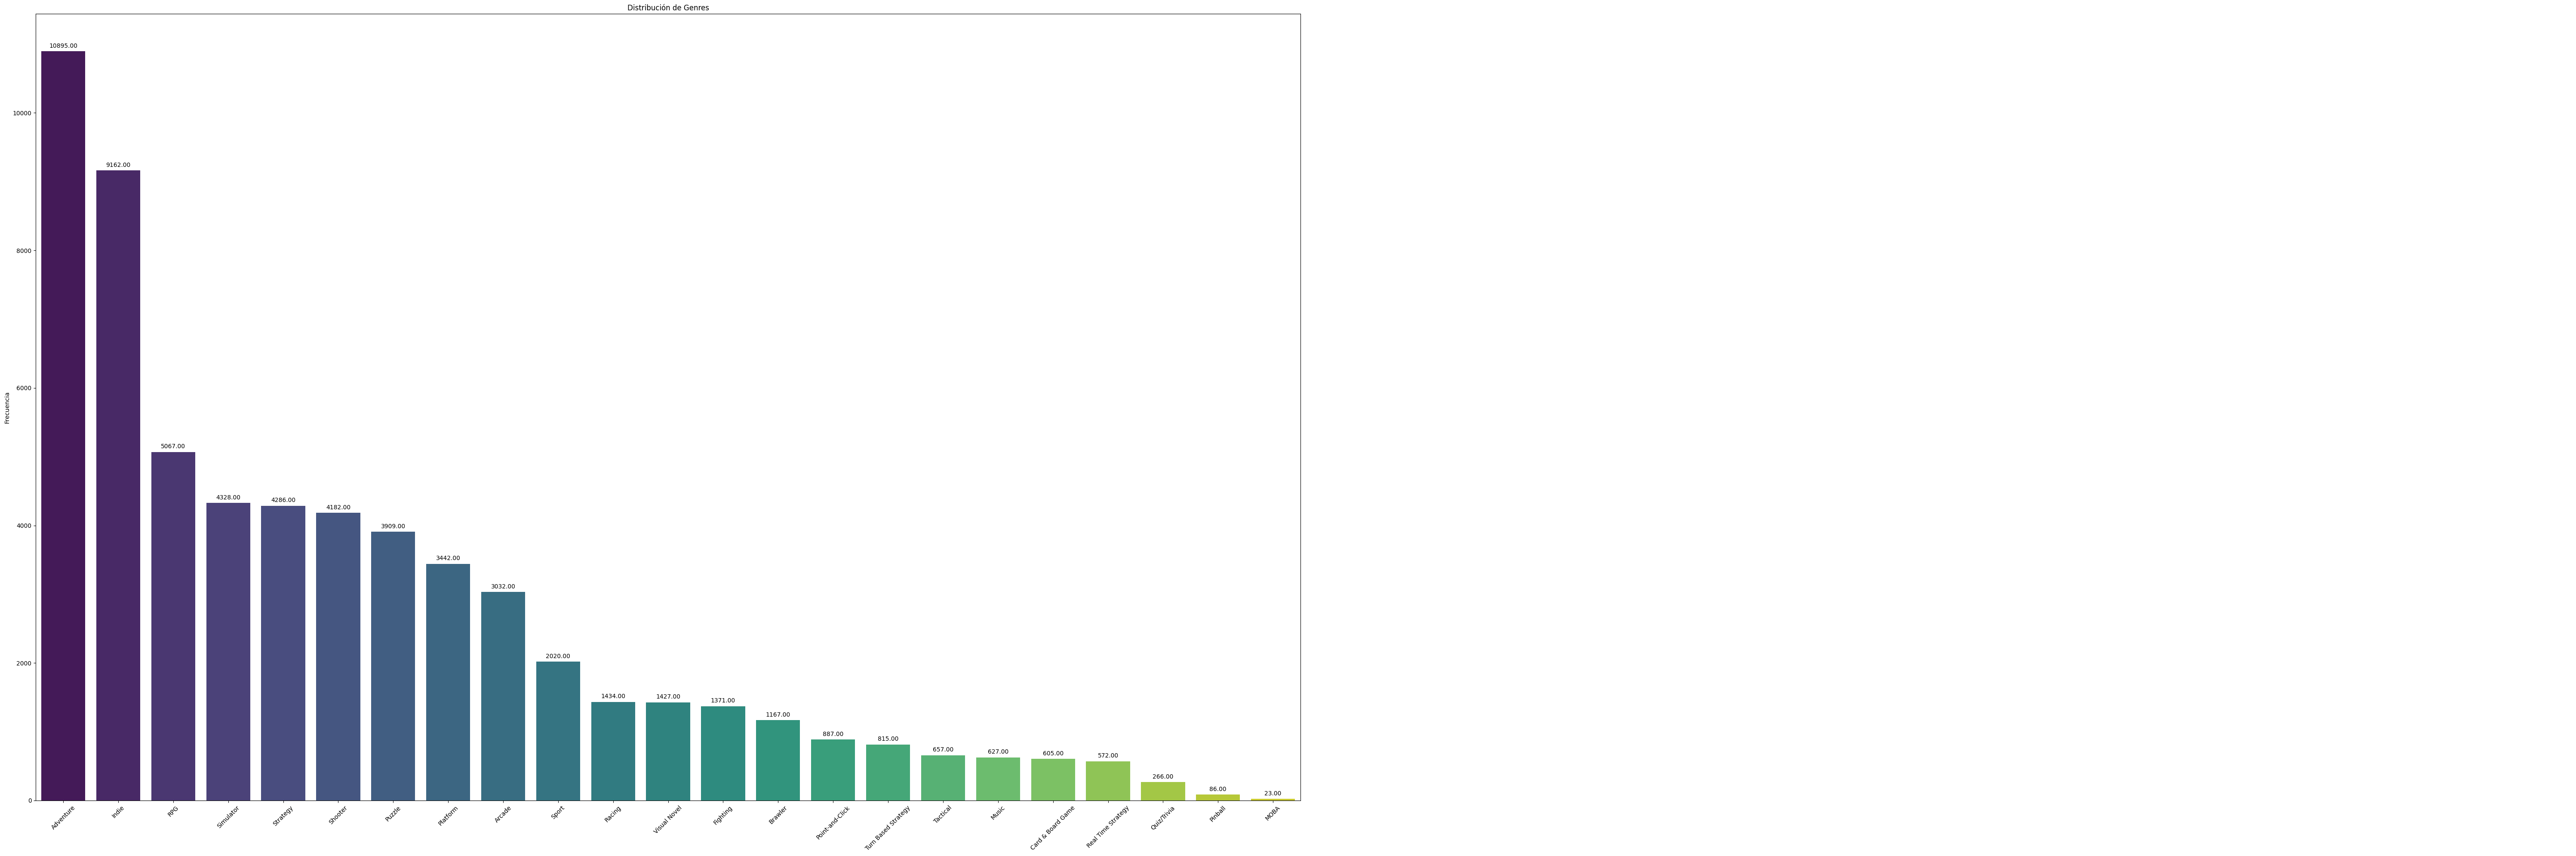

In [110]:
# FRECUENCIA ABSOLUTA EN GENRES

top_n = 30  
Funciones.pinta_distribucion_categoricas(df_exploded_genres, ['Genres'], top_n=top_n, mostrar_valores=True)


In [40]:
# Compruebo que la moda corresponde a 'Adventure' que es la categoría con más juegos
moda_genres = df_exploded_genres['Genres'].mode()
moda_genres

0    Adventure
Name: Genres, dtype: object

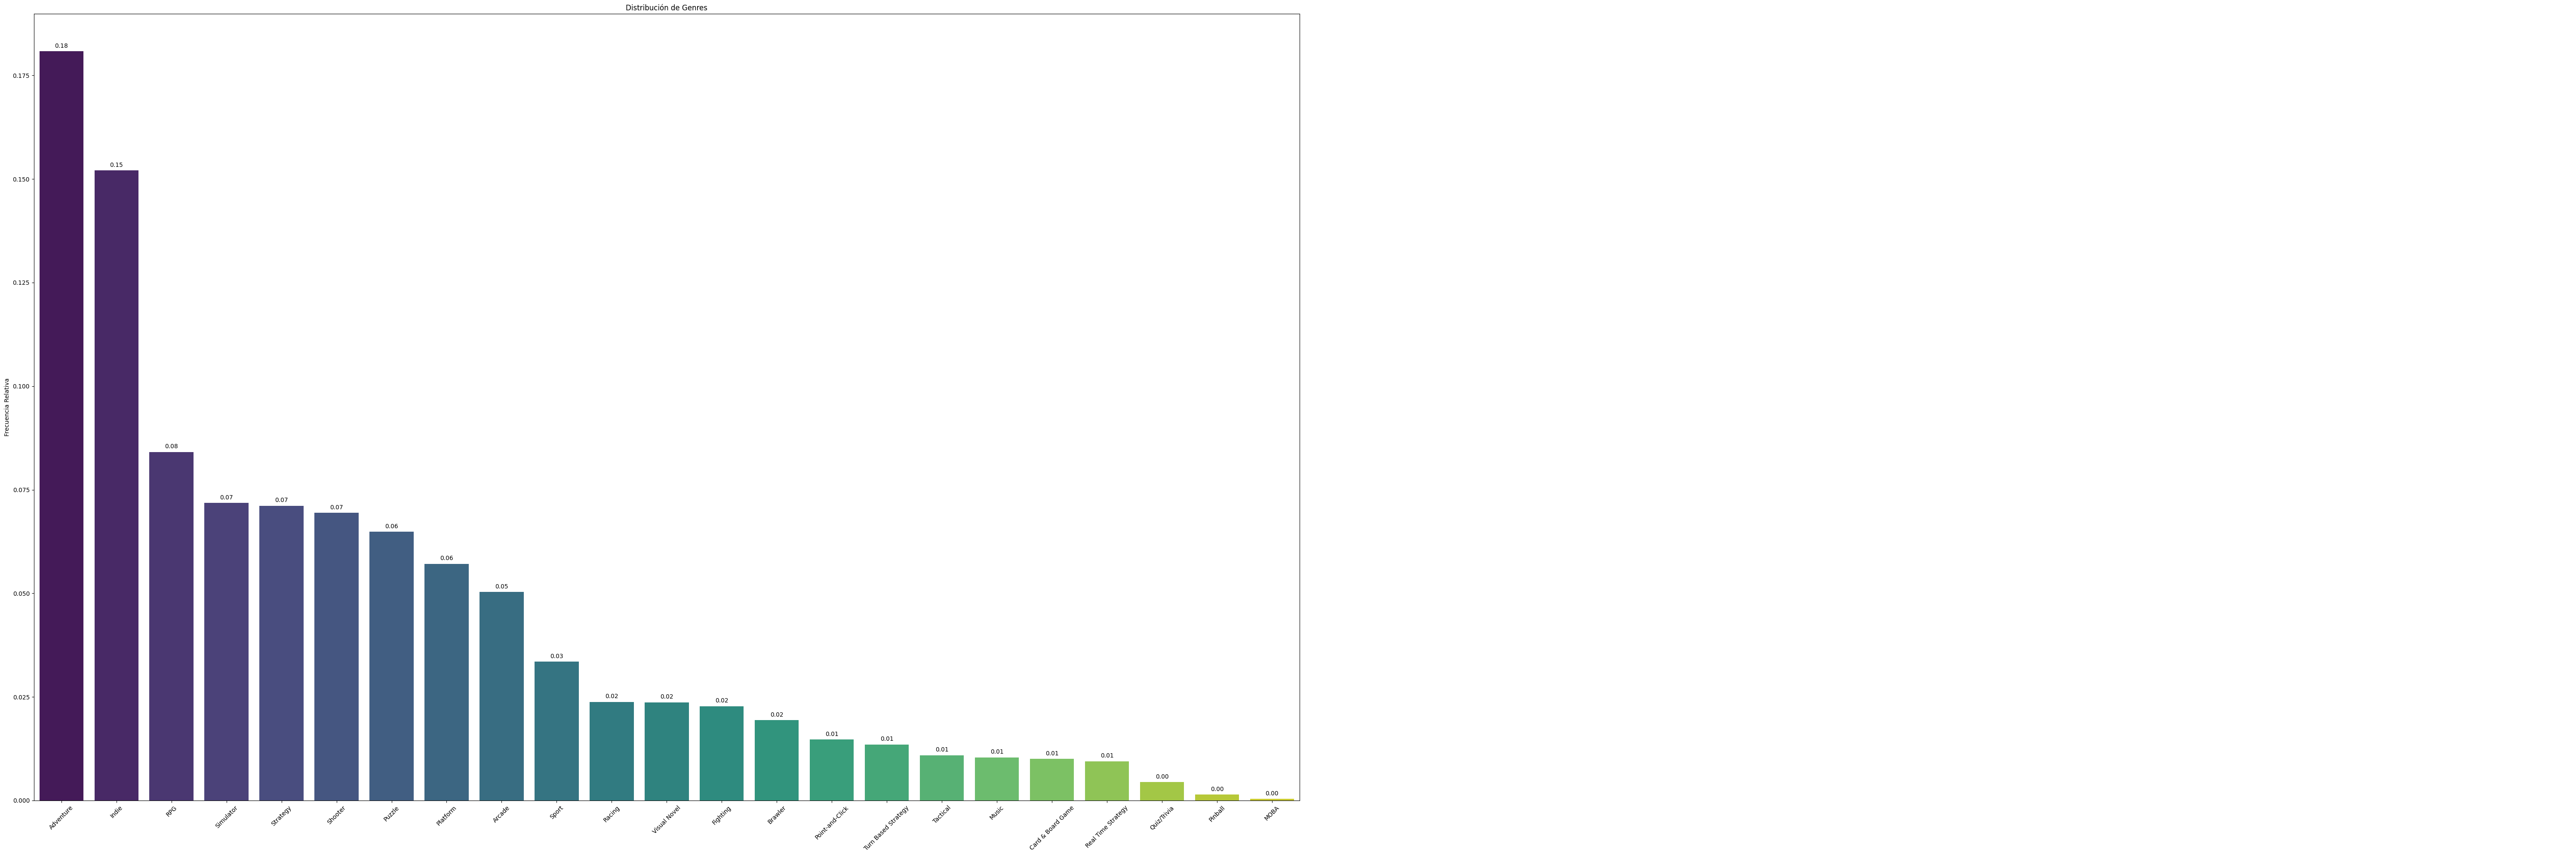

In [111]:
# FRECUENCIA RELATIVA EN GENRES
top_n = 30  
Funciones.pinta_distribucion_categoricas(df_exploded_genres, ['Genres'], top_n=top_n, relativa=True, mostrar_valores=True)

In [112]:
# Compruebo que las frecuencias relativas son las correctas, en el gráfico aparecen todas las categorías y tienen que sumar 1
total = df_exploded_genres['Genres'].value_counts(normalize=True).sum() # normalize=True modifica value_counts para que en lugar de devolver el recuento total de cada valor, devuelva la proporción
print(total)


1.0


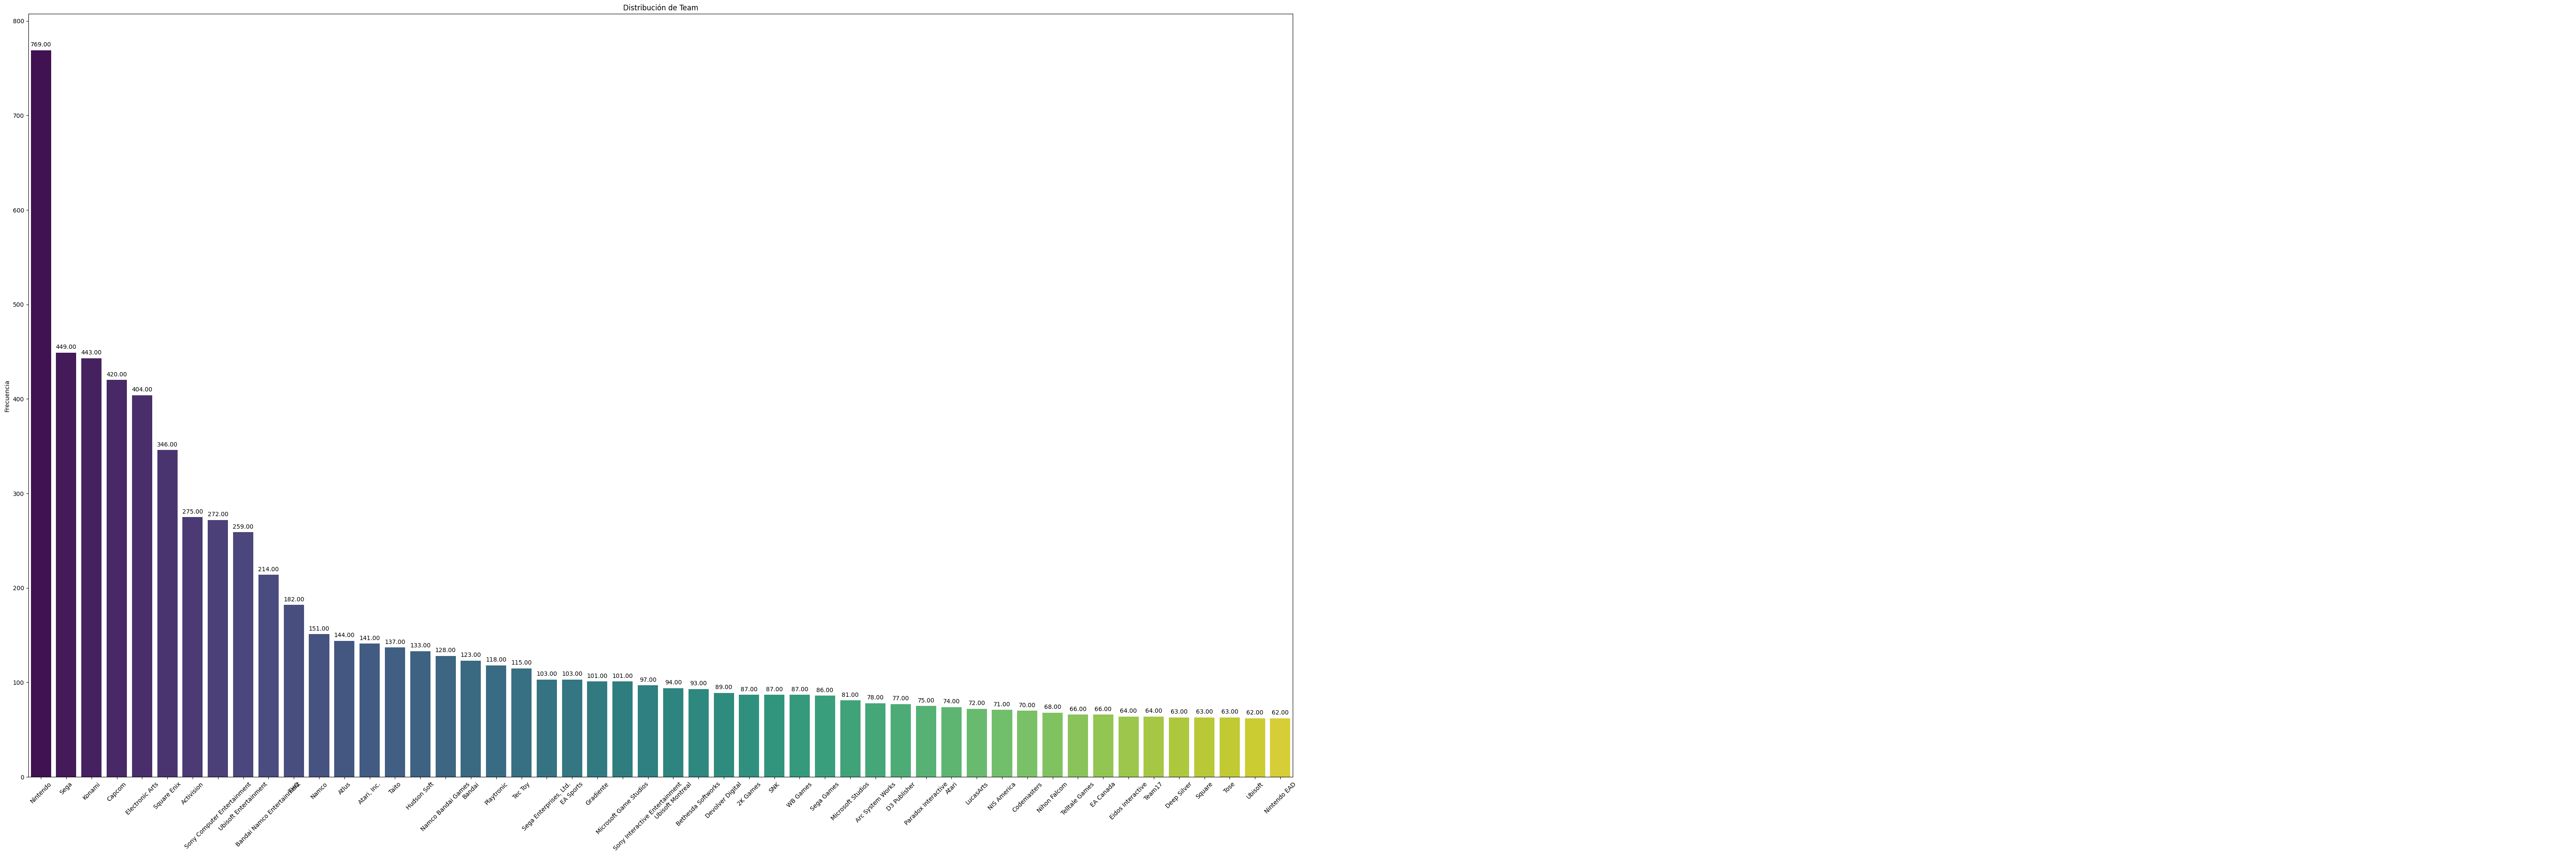

In [113]:
top_n = 50  
Funciones.pinta_distribucion_categoricas(df_exploded_team, ['Team'], top_n=top_n, mostrar_valores=True)

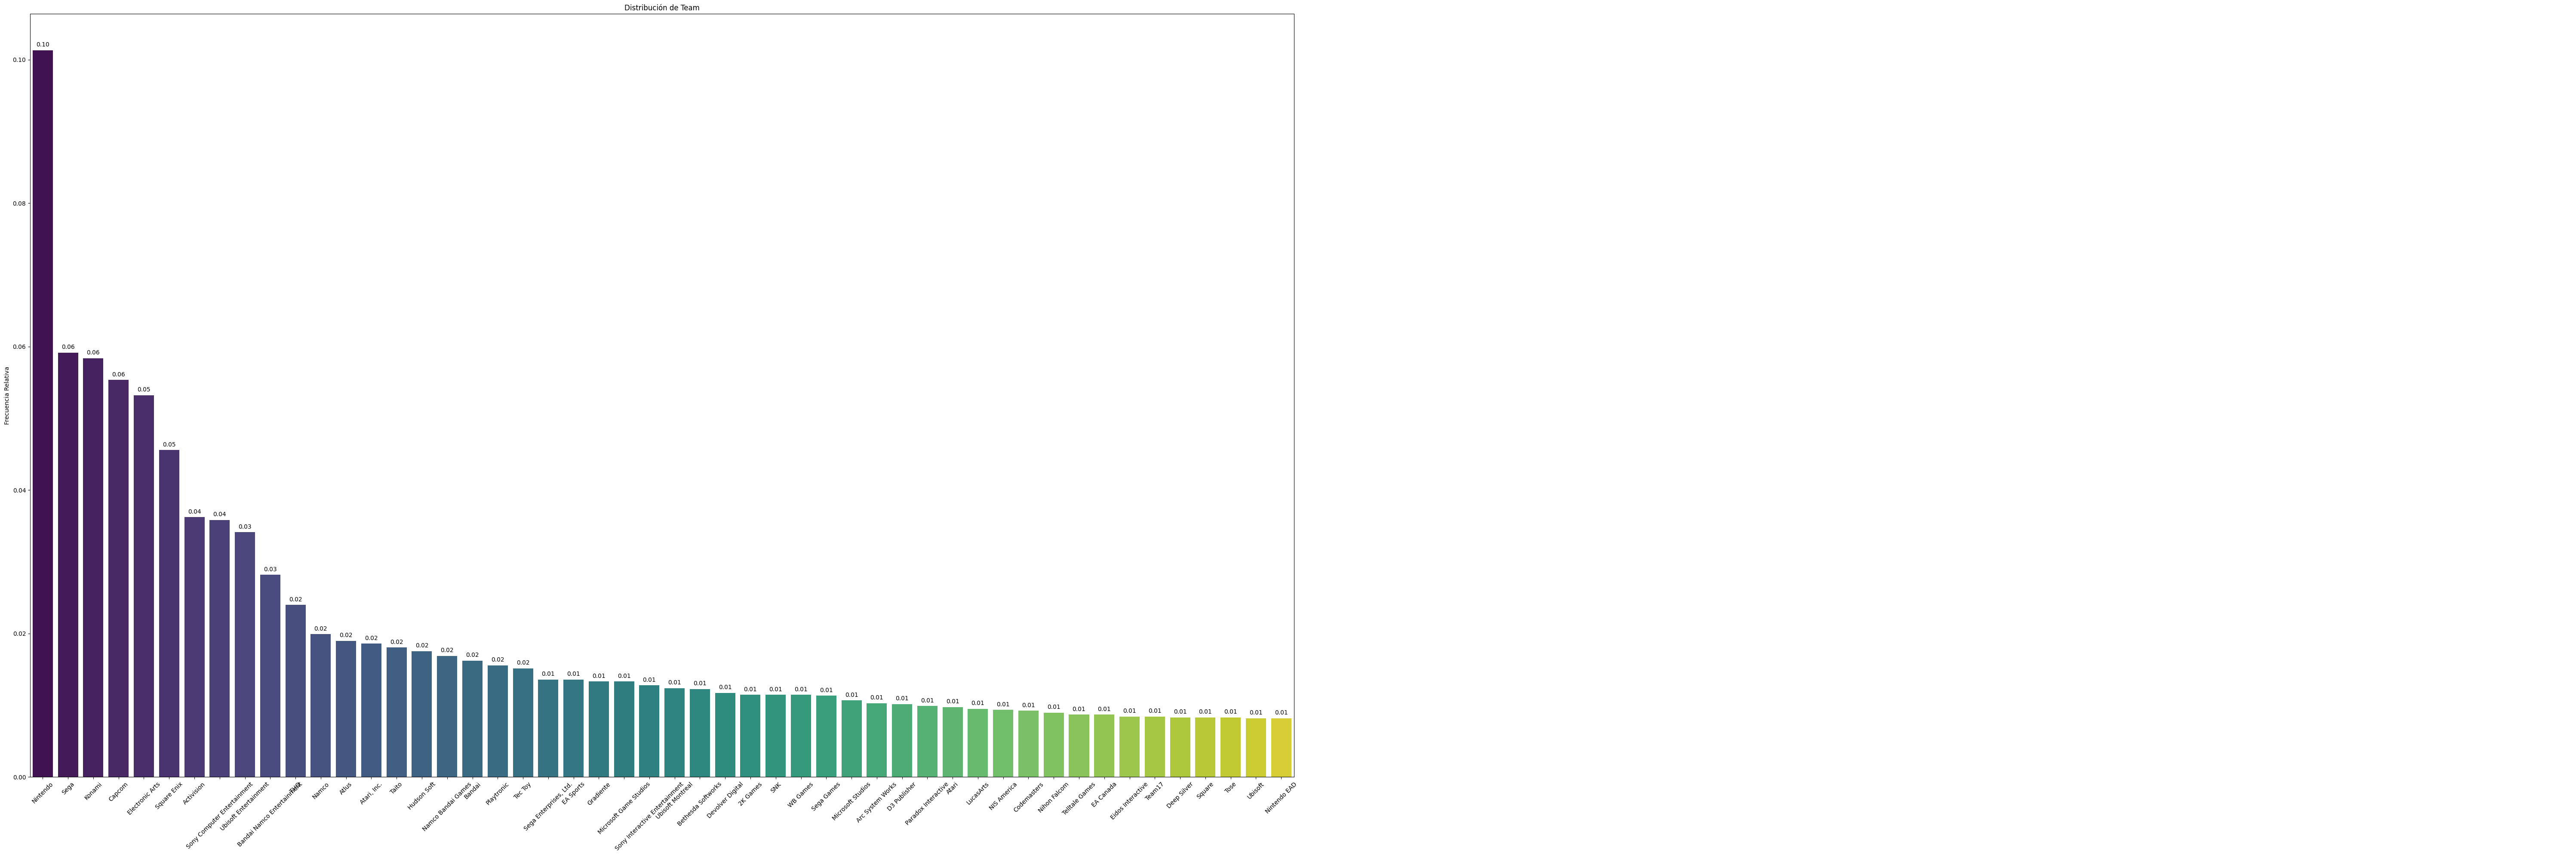

In [114]:
top_n = 50  
Funciones.pinta_distribucion_categoricas(df_exploded_team, ['Team'], top_n=top_n, relativa=True, mostrar_valores=True)

In [44]:
# Compruebo que la moda corresponde a 'Nintendo' que es la compañía con más juegos 
moda_team = df_exploded_team['Team'].mode()
moda_team

0    Nintendo
Name: Team, dtype: object

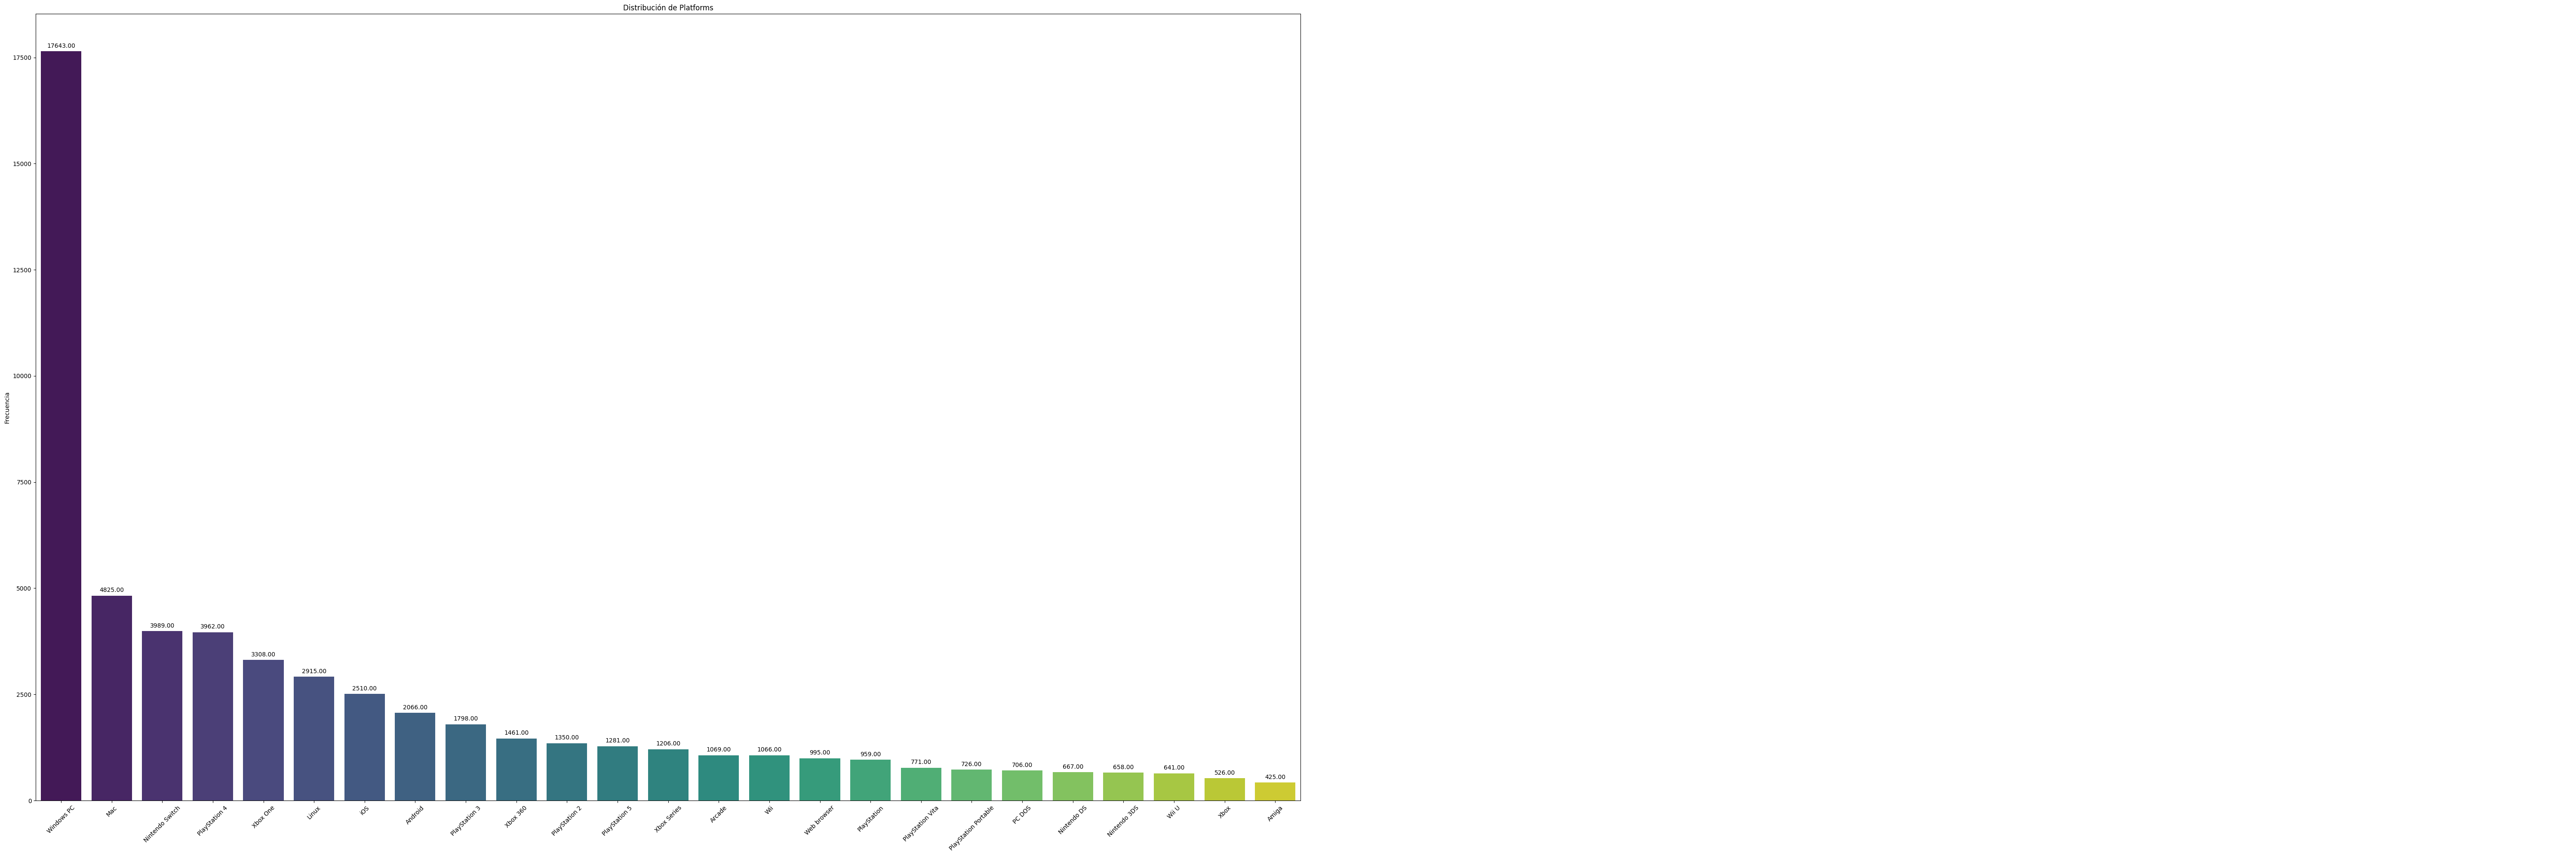

In [115]:
top_n = 25  
Funciones.pinta_distribucion_categoricas(df_exploded_platform, ['Platforms'], top_n=top_n, mostrar_valores=True)

In [55]:
# Comprueno que el gráfico está bien; para ello filtro por el df explotado por el numero total de filas filtradas por la plataforma 'Windows PC'

# Filtrar filas donde la plataforma es 'Windows PC'
windows_pc_games = df_exploded_platform[df_exploded_platform['Platforms'] == 'Windows PC']

windows_pc_games

,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist,GameID
0,Elden Ring,2022-02-25,"[FromSoftware, Bandai Namco Entertainment]",4.5,6200,"[Adventure, RPG]","Elden Ring is a fantasy, action and open world...","['👍', 'A good effort from konami, but at the e...",Windows PC,33000,5200,8700,7300,0
3,Hades,2018-12-07,[Supergiant Games],4.3,4200,"[Adventure, Brawler, Indie, RPG]",A rogue-lite hack and slash dungeon crawler in...,"[""I enjoyed it quite a bit, but with games lik...",Windows PC,35000,4400,10000,5300,3
4,Hollow Knight,2017-02-24,[Team Cherry],4.4,4600,"[Adventure, Indie, Platform]",A 2D metroidvania with an emphasis on close co...,"['This game is perfect, I immediately fell in ...",Windows PC,35000,3600,13000,3600,4
5,Undertale,2015-09-15,"[tobyfox, 8-4]",4.3,5100,"[Adventure, Indie, RPG, Turn Based Strategy]","A small child falls into the Underground, wher...","[""I can't explain how much I love this game. T...",Windows PC,43000,984,8200,2900,5
6,Resident Evil 4,2023-03-24,"[Capcom, Capcom Development Division 1]",4.5,3500,"[Adventure, Puzzle, Shooter]",Resident Evil 4 is a remake of the 2005 origin...,['This is really good.\n \...,Windows PC,13000,1300,4300,5600,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30200,Debris,2011-07-25,[Harinezumi],3.8,8,[Adventure],"Debris is a Japanese Yume Nikki fangame, where...","['GODDAMN.', 'imbecil', 'Not perfect, but stil...",Windows PC,7,1,7,3,30200
30201,Tunnel Rats,2009-04-05,"[Replay Studios, Boll AG]",3.1,6,[Shooter],Tunnel Rats is a dark and intense single-playe...,['Truly a classic among bad games. If only it ...,Windows PC,4,1,3,4,30201
30202,Another Way,2014-04-20,[],3.1,3,[Adventure],Another Way is an English Yume Nikki fangame. ...,[],Windows PC,1,0,1,0,30202
30203,Wild Hearts: Karakuri Edition,2023-02-16,[],3.1,1,[],Wild Hearts is a twist on the hunting genre wh...,[],Windows PC,3,0,3,1,30203


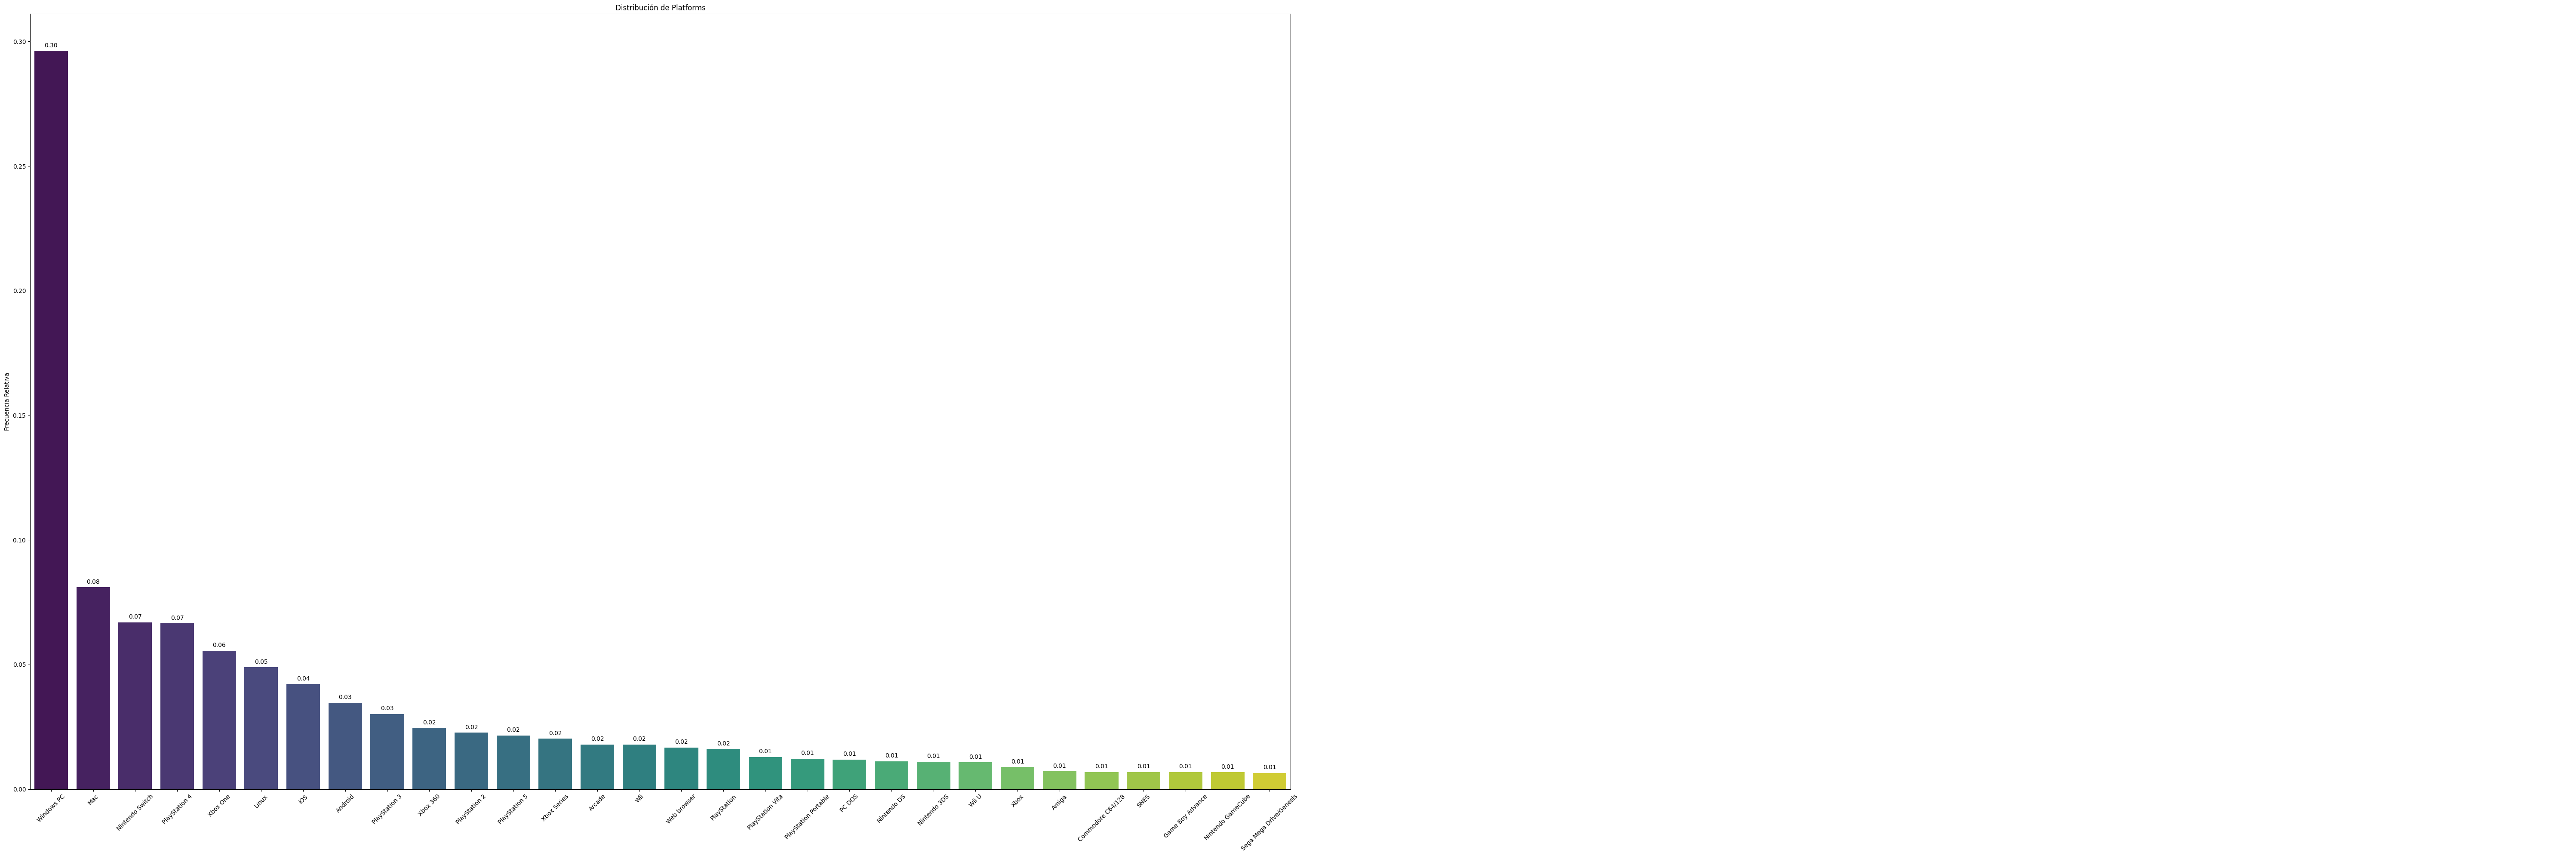

In [28]:
top_n = 30  
Funciones.pinta_distribucion_categoricas(df_exploded_platform, ['Platforms'], relativa=True, top_n=top_n, mostrar_valores=True)

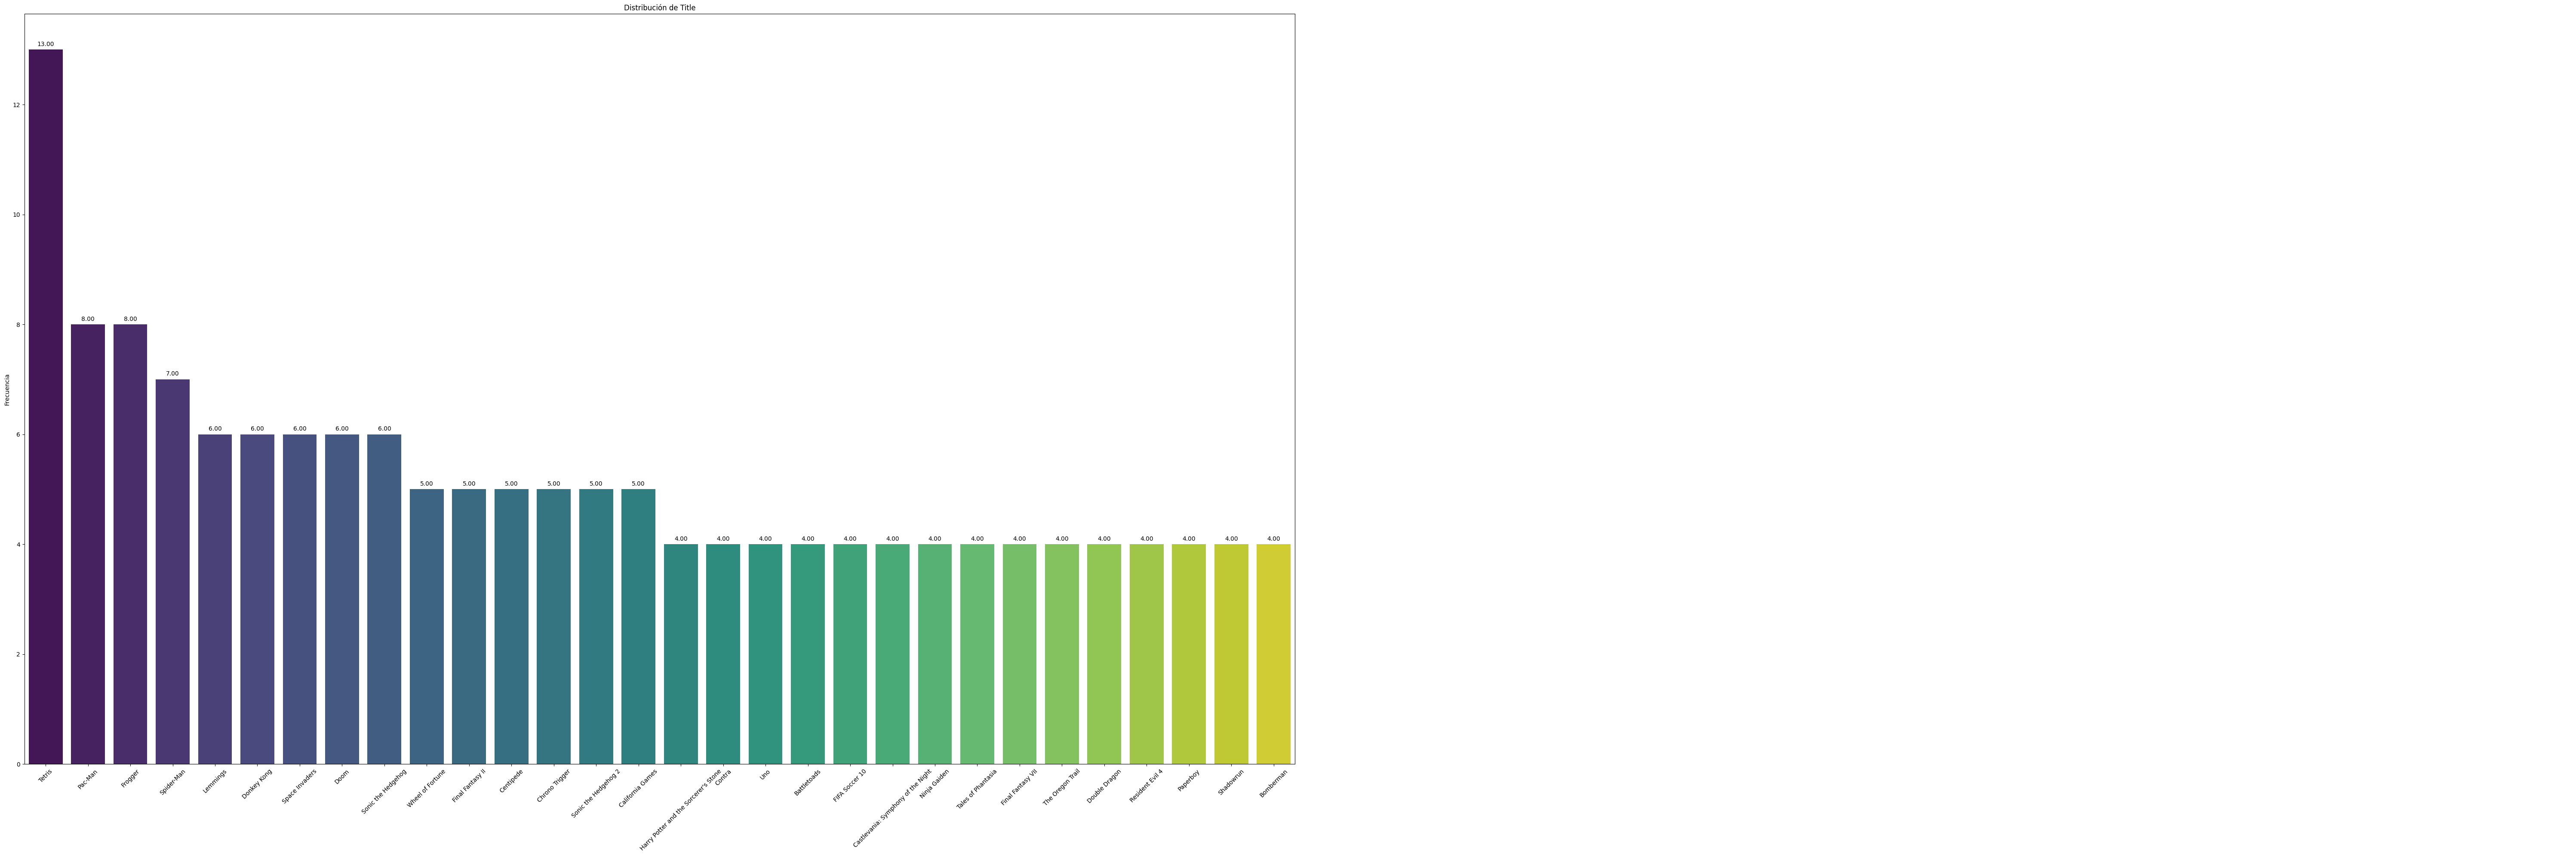

In [30]:
top_n = 30  
Funciones.pinta_distribucion_categoricas(df, ['Title'], top_n=top_n, mostrar_valores=True)

In [29]:
# Compruebo que los datos de la gráfica está bien --> Tetris aparece como el juego más repetido por título (son versiones diferentes)
# Tanto en la gráfica como si busco filas que tengan ese nombre en la columna títuo aparecen por ese nombre
nombre_del_juego = "Tetris"
fila_del_juego = df[df['Title'] == nombre_del_juego]
fila_del_juego

,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist
411,Tetris,1989-11-01,"[Playtronic, Nintendo]",4.1,947,"[Arcade, Puzzle]",Tetris is a tile-matching puzzle video game. T...,"[""not as good as Dr. Robotnik's Mean Bean Mach...",[NES],13000,73,265,105
1075,Tetris,1989-05-14,"[Playtronic, Nintendo]",4.0,404,[Puzzle],Tetris is a puzzle video game for the Game Boy...,"['Tetris on the GB was amazing, and still is a...","[Nintendo 3DS, Game Boy]",4300,28,145,32
9571,Tetris,2006-09-12,"[EA, Apple]",2.9,6,[Puzzle],Tetris is a licensed Tetris game for Fifth-Gen...,['iPhone :('],[iOS],16,0,0,0
10591,Tetris,1984-06-06,[Alexey Pajitnov],4.1,76,"[Arcade, Puzzle]",The original version of Tetris was created by ...,"[""Y'know, I'm not quite sure how I should rate...",[Legacy Computer],139,0,23,12
13044,Tetris,2006-12-31,"[Sanritsu Denki Co., Ltd., Sega]",2.8,7,[],Tetris was a game for the Sega Mega Drive that...,['No entiendo por qué pone TBD\n ...,"[Sega Mega Drive/Genesis, Arcade]",10,0,2,0
15235,Tetris,1989-12-31,[Sega],3.1,4,"[Arcade, Puzzle]",The System E Arcade System port of Sega's Tetris.,['Cultural merit: 4/5\n \n...,[Arcade],5,0,1,0
15999,Tetris,1991-12-31,[Tokyo System House],3.1,3,[Puzzle],Tetris for the NEC Mini5.,[],[Legacy Computer],1,0,0,0
16979,Tetris,1989-05-01,[Tengen],3.9,22,[Puzzle],"Tengen, an Atari label, released an unlicensed...","['Joguei muito antigamente.', 'This is obvious...",[NES],108,0,14,11
18972,Tetris,1984-12-31,[Vadim Gerasimov],3.3,7,"[Arcade, Puzzle]",The second version of Tetris was programmed by...,[],[PC DOS],15,0,1,1
26880,Tetris,2009-08-24,"[EA Mobile, EA]",3.1,38,"[Puzzle, Strategy]",Don't miss out on one of the best-selling mobi...,['stopped going to therapy when i realized i c...,"[Android, iOS, PlayStation 3, Windows Phone, B...",517,6,18,8


In [46]:
# Además, si busco su moda también aparece Tetris como resultado
moda_title = df['Title'].mode()
print(moda_title)

0    Tetris
Name: Title, dtype: object


<a id="Variables-Categoricas-Conclusiones-Finales"></a>
## Variables Categoricas: Conclusiones Finales

## **Análisis de Variables Categóricas en el Dataset de Videojuegos**

El dataset está formado por las siguientes Variables Categóricas:['Title', 'Team', 'Genres', 'Summary', 'Reviews', 'Platforms'] En mi inmersión en el mundo de los videojuegos a través del análisis de datos, me he enfocado en las variables que forman la esencia de la industria: `Title`, `Team`, `Genres` y `Platforms`. Estas son las columnas que pinto como pilares para comprender la alta diversidad que el mercado de videojuegos ofrece. Una vez avancemos más en el bootcamp, podré crear modelos que me ayuden a sacar insights interesantes a través de textos largos como se da en el caso de `Summary` y `Reviews`.

### **Cardinalidad y Diversidad**

El primer paso en mi análisis fue evaluar la cardinalidad de las variables:

- **Title**: Con una cardinalidad del 97.61%, me sorpredió que esta no fuera del 100%. La razón es porque hay bastante títulos que tienen exactamente el mismo nombre. Suele tratarse de juegos que han sido tan populares en épocas pasadas que se han creado nuevas versiones adaptadas a los nuevos tiempos en las que han utlizando literalmente el mismo nombre. Entiendo que habrán permitido hacerlo bajo licencia. En otras ocasiones se trata del mismo juego pero específico para ciertas plataformas, es decir, el mismo desarrollador tiempo después lanza una versión optimizada para un dispositivo concreto. El ejemplo más llamativo es el del famoso videjuego 'Tetris', el cual tiene hasta 13 versiones diferentes.

Un dato a destacar, es que la primera vez que analicé la cardinalidad me pareció muy raro los %  de valores únicos que obtenía en muchas de ellas. Por ello, en las variables ['Genres', 'Team', 'Platforms'] tuve que realizar una serie de tratamientos, como la 'explotación' de la las listas para poder conocer realmente el número real de elementos diferentes que existían. Poniendo un ejemplo: Esto ocurre cuando un videjuego tiene más de un valor etiquetado a una variable por ejemplo, en 'Genres' hay 1216 valores para ['Adventure', 'Indie'] 1132 para ['Indie'] y 1296 para ['Adventure']. Por ello, lo que realmente quería era que no hubiera conjuntos, sino que, siguiendo el caso, sólo hubiera 'Indie' y 'Adventure' y si un juego estaba categorizado en ambas, se contabilizara ese juego una vez en 'Indie' y otra en 'Adventure'. Ahora de esta manera ya podía obtener las frecuencias reales de estas columnas.

- **Team**: Un 26.87% de cardinalidad me indicó un mercado con una considerable cantidad de desarrolladores y estudios. Algo que me sorprendió mucho ya que esperaba una cardinalidad mucho más alta. La razón es que existen una gran cantidad de equipos, muchos de ellos muy jóvenes, que normalmente han producido una cantidad muy baja de videjuegos, de hecho muchos de ellos sólo han creado uno. Existen dos razones principales: 1- Que llevan pocos años en la industria, 2- Que al realizar su primer juego no llegaron a los números esperados y tuvieron que abandonar la compañía.

- **Genres**: Con una cardinalidad de solo el 0.04%, era algo bastante lógico. ya que una vez hice la explotación de las listas sólo se identificaron 23 géneros únicos.

- **Platforms**: Con una cardinalidad del 0.26%. Aunque esperaba una cardinalidad muy baja, igualmente me pareció bastante alta, ya que se traducía a que existen unas 176 plataformas diferentes. La razón es porque además de incluir la mayoría de consolas que todos conocemos, también existen juegos muy específicos para ciertos softwares o hardwares + sofwares que son muy desconocidos para la mayoría de personas. De todas maneras, lo que pude confirmar es que, a pesar de la existencia de múltiples plataformas, unas pocas dominan el mercado.

### **Gráficos de Barras**



#### **Análisis de Géneros**

Los gráficos de barras me llevaron a observar que ciertos géneros son significativamente más populares que otros. Algunas conclusiones que puede sacar:

- `Adventure` es el género por excelencia, en principio, no me sorprende que esté el número uno, ya que además de que es muy popular, en las primeras décadas la mayoría no existían apenas géneros y la mayoría de juegos era de aventuras.
- `Indie` posicionado en segundo lugar, me sorpredió enormemente; sin realizar este análisis jamás hubiera acertado si me hubierán preguntado. Tratándome de adelantar al análisis bivariante, creo que puede ser porque la mayoría de equipos que empiezan, utilizan este género 'alternativo' ya que no se necesitan tantos recursos para llevarlo a cabo. Por lo que, que existan muchos videjuegos en una categoría no tiene por qué significar que sea más exitoso, ya que necesitan menos jugadores para poder cubrir costes y sacar algo de beneficio

#### **Análisis de Equipos**

- Existen un gran número de equipos, pero se nota un gran número de valores extremos que indican que la mayoría de los juegos los producen las grandes empresas y que aunque existen muchos equipos, estos normalmente producen una cantidad muuy pequeña del total del mercado, además que suelen tratrse de juegos enfocados en categorías más alternativas como la `Indie`
- Me ha llamado la atención la cantidad de videjuegos producidos por `Nintendo`. Es una estrategia brillante: además de suministrar plataformas exitosas, como Nintendo SWitch, producen la mayoría de los videjuegos para las mismas. Además como conocen perfectamente el hardware, desarrollarán juegos totalmente optimizados y al tener menos % de bugs, tendrán a las comunidades más contentas y con mejores reviews.

Los gráficos de barras me llevaron a observar que ciertos géneros son significativamente más populares que otros. Esto no solo afecta la estrategia de desarrollo de nuevos juegos, sino que también puede influir en las campañas de marketing y en las decisiones de contenido.


#### **Análisis de Plataformas**

- La gran campeona con mucha diferencia frente al resto `Windows PC`, me sorepdió el hecho que la diferencia frente al resto de plataformas fuera tan abismal. En ese sentido, me sorepndió que hubiese tanta diferencia entre videjuegos que estuvieran disponibles en Windows y no en `Mac`.
- Resulta interesante el gran empuje que están teniendo las últimas versiones de plataformas populares como `PlayStation`, las cuales ofrecen más videjuegos que algunas de sus versiones antiguas teniendo en cuenta que llevan muchos menos años en el mercado.
- También considero interesante el gran número de plataformas más desconocidas y la gran variedad de títulos que tienen disponibles para ser nicho (en términos relativos son muy pocos comparados con las consolas populares)



#### **Conclusión Preliminar**

La combinación de estos análisis, apoyada en la explotación de datos, me ha proporcionado una base sólida para comprender la estrctura básica y las variables categóricas del dataset. Me quedó claro que, aunque hay una amplia variedad en títulos y equipos, géneros y plataformas, pocos de ellos entérminos relativos capturan la atención mayoritaria. 




<a id="Variables-Numericas-Medidas-Posicionales"></a>
## Variables Numericas: Medidas Posicionales

In [32]:
columnas_numericas = ['Avg. Rating', 'Times Listed', 'Plays', 'Playing', 'Backlogs', 'Wishlist']

In [116]:
print(df["Avg. Rating"].quantile(0.5),
    df["Avg. Rating"].quantile(0.9), 
      df["Avg. Rating"].quantile(0.95),
     df["Avg. Rating"].max())

3.1 3.7 4.0 5.0


In [117]:
print(df["Plays"].quantile(0.5),
    df["Plays"].quantile(0.9), 
      df["Plays"].quantile(0.95),
     df["Plays"].max())

9.0 872.0 2500.0 53000


In [34]:
df['Avg. Rating'].describe()

count    30208.000000
mean         3.097007
std          0.531258
min          0.200000
25%          3.100000
50%          3.100000
75%          3.300000
max          5.000000
Name: Avg. Rating, dtype: float64

In [35]:
# Función para obtener el índice intercuartilico
def get_IQR(df, col):
    return df[col].quantile(0.75) - df[col].quantile(0.25)

In [42]:
get_IQR(df,"Avg. Rating")

0.19999999999999973

In [37]:
get_IQR(df,"Times Listed")

33.0

In [38]:
get_IQR(df,"Plays")

116.0

In [39]:
get_IQR(df,"Playing")

2.0

In [40]:
get_IQR(df,"Backlogs")

42.0

In [41]:
get_IQR(df,"Wishlist")

21.0

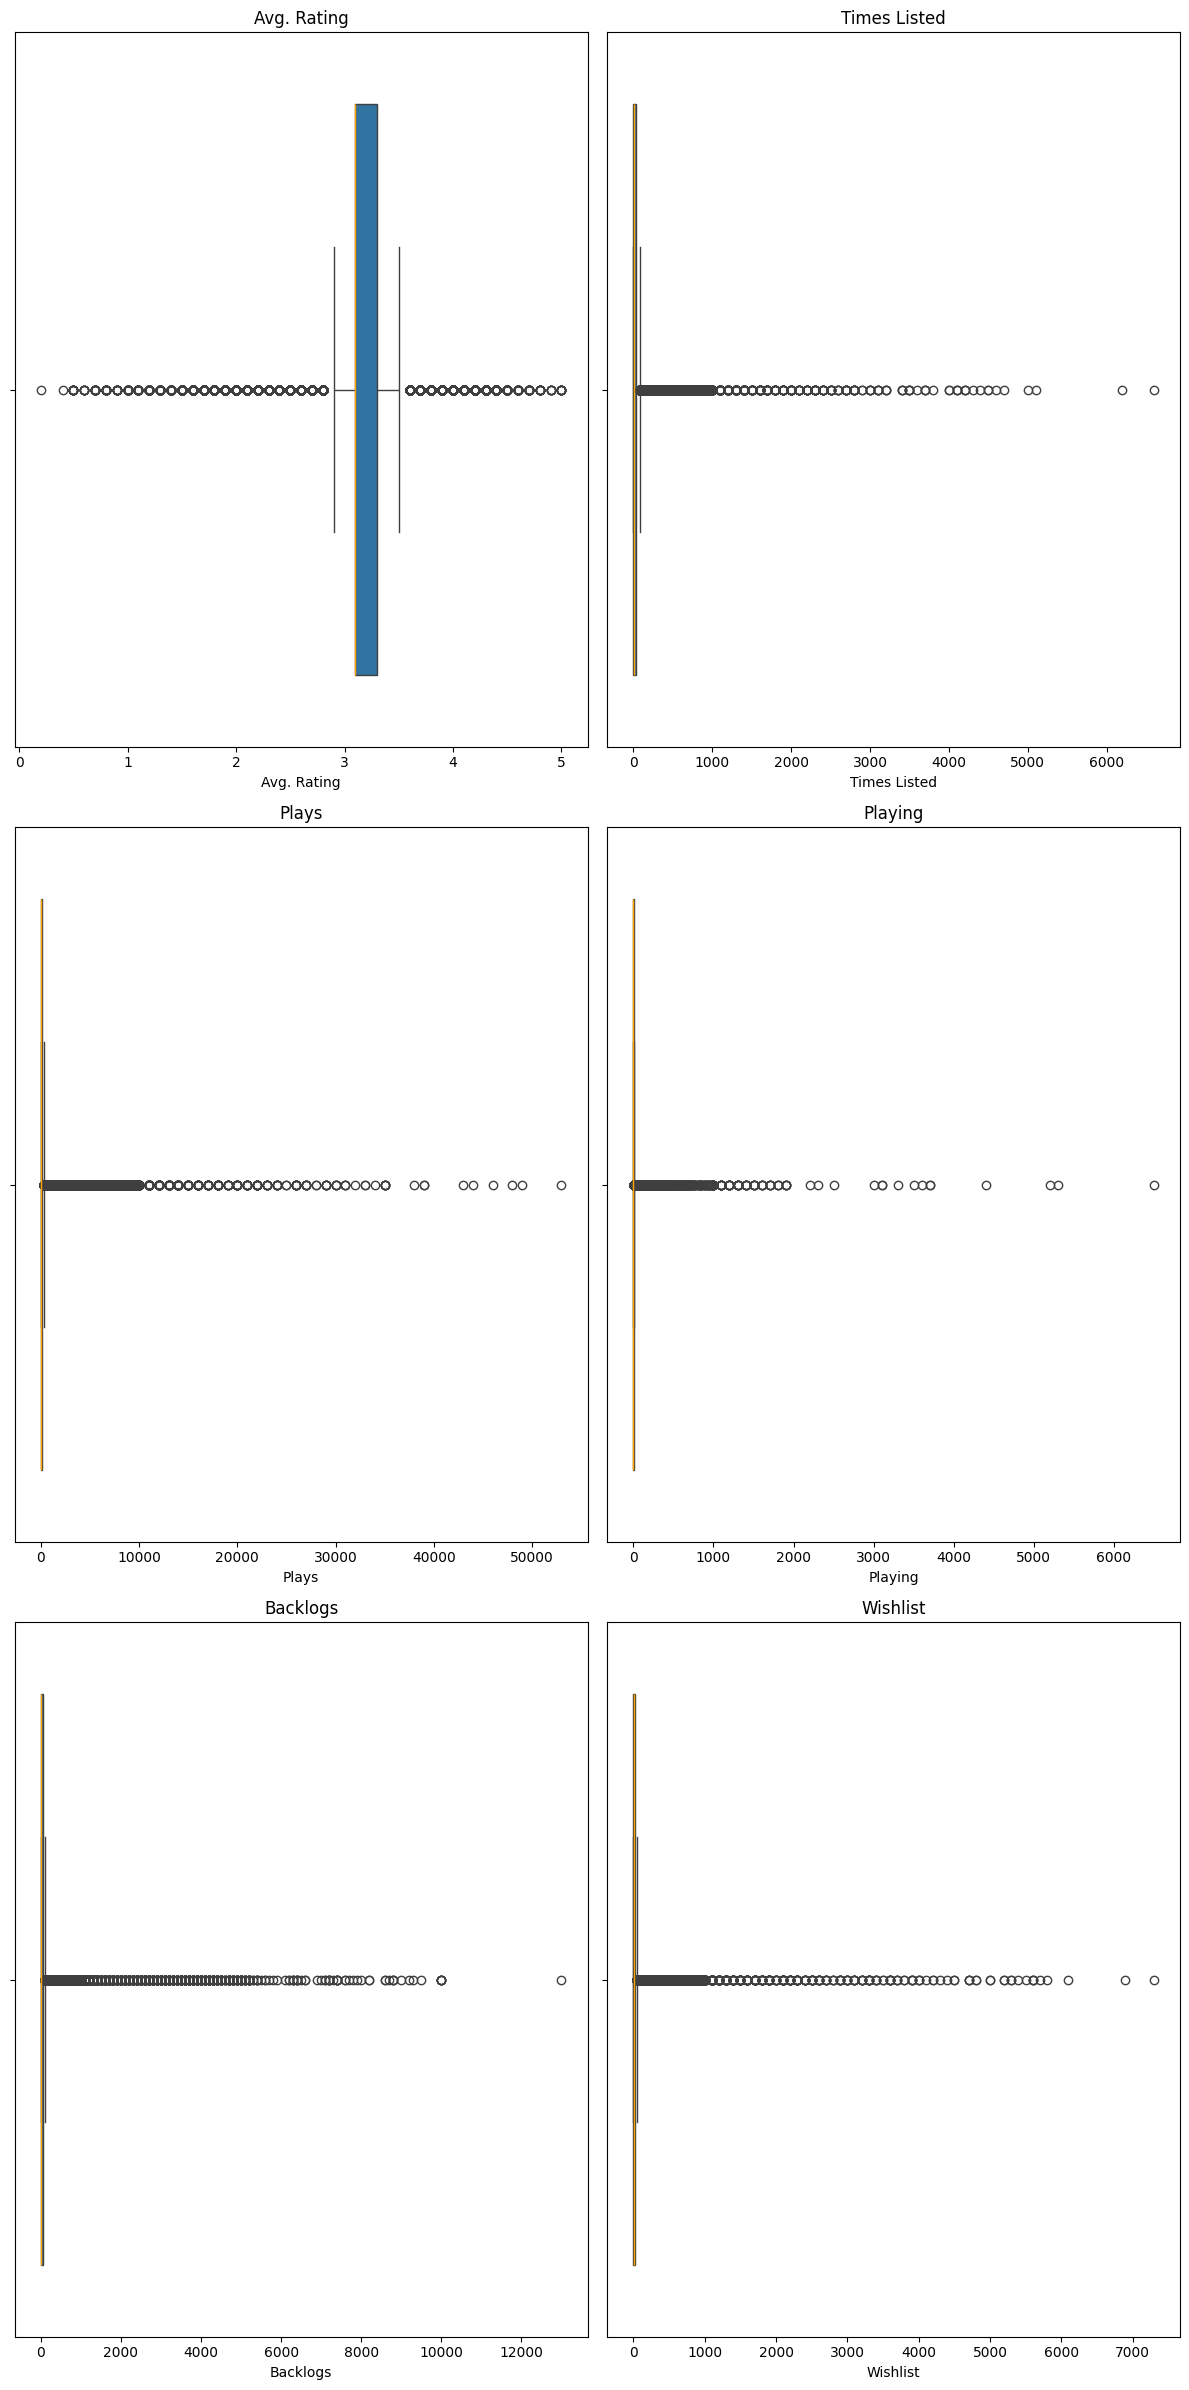

In [118]:
Funciones.plot_multiple_boxplots(df, columnas_numericas, dim_matriz_visual=2,log_scale=False)

In [50]:
# Una comprobación de que los datos son correctos; para ello, calculo los valores dentro de la caja central de 'Plays'

# Cálculo de los cuartiles
Q1 = df['Plays'].quantile(0.25)
Q3 = df['Plays'].quantile(0.75)
IQR = Q3 - Q1 # Cálculo de la caja central

# Número total de juegos dentro del IQR
iqr_plays = df[(df['Plays'] >= Q1) & (df['Plays'] <= Q3)]
total_iqr_plays = iqr_plays.shape[0]

# Porcentaje que estos representan en el dataframe
porcentaje_iqr_plays = (total_iqr_plays / len(df)) * 100

print(f"Número total de juegos dentro del IQR de la variable 'Plays': {total_iqr_plays}")
print(f"Porcentaje de juegos dentro del IQR de la variable 'Plays': {porcentaje_iqr_plays:.2f}%")


Número total de juegos dentro del IQR de la variable 'Plays': 18147
Porcentaje de juegos dentro del IQR de la variable 'Plays': 60.07%


In [48]:

# Número total de juegos con 0 en la columna 'Plays'
total_juegos_con_0_plays = (df['Plays'] == 0).sum()

# Ahora calculamos el porcentaje que estos representan en el dataframe
porcentaje_con_0_plays = (total_juegos_con_0_plays / len(df)) * 100

print(f"Número total de juegos con 0 en 'Plays': {total_juegos_con_0_plays}")
print(f"Porcentaje de juegos con 0 en 'Plays': {porcentaje_con_0_plays:.2f}%")


Número total de juegos con 0 en 'Plays': 4513
Porcentaje de juegos con 0 en 'Plays': 14.94%


In [43]:
# Obtengo la mediana de todas las variables numéricas
df.describe().loc["50%"]

Release Date    2015-07-23 00:00:00
Avg. Rating                     3.1
Times Listed                    4.0
Plays                           9.0
Playing                         0.0
Backlogs                        4.0
Wishlist                        2.0
Name: 50%, dtype: object

In [131]:
# Diferencia entre el máximo y mínimo valor para cada una de las variables numéricas
df.describe().loc["max"] - df.describe().loc["min"]

Release Date    22068 days 00:00:00
Avg. Rating                     4.8
Times Listed                 6600.0
Plays                       53000.0
Playing                      6500.0
Backlogs                    13000.0
Wishlist                     7300.0
dtype: object

<a id="Variables-Numericas-Desviacion"></a>
## Variables Numericas: Desviacion

In [119]:
Funciones.variabilidad(df)

,std,mean,CV
Release Date,nan,2011-11-12 06:55:52.118643968,nan%
Avg. Rating,0.531258,3.097007,17.15%
Times Listed,260.565944,73.611527,353.97%
Plays,2238.989865,525.286679,426.24%
Playing,119.980305,16.726794,717.29%
Backlogs,563.642680,142.501126,395.54%
Wishlist,294.548148,69.293200,425.08%
GameID,8720.442802,15103.500000,57.74%


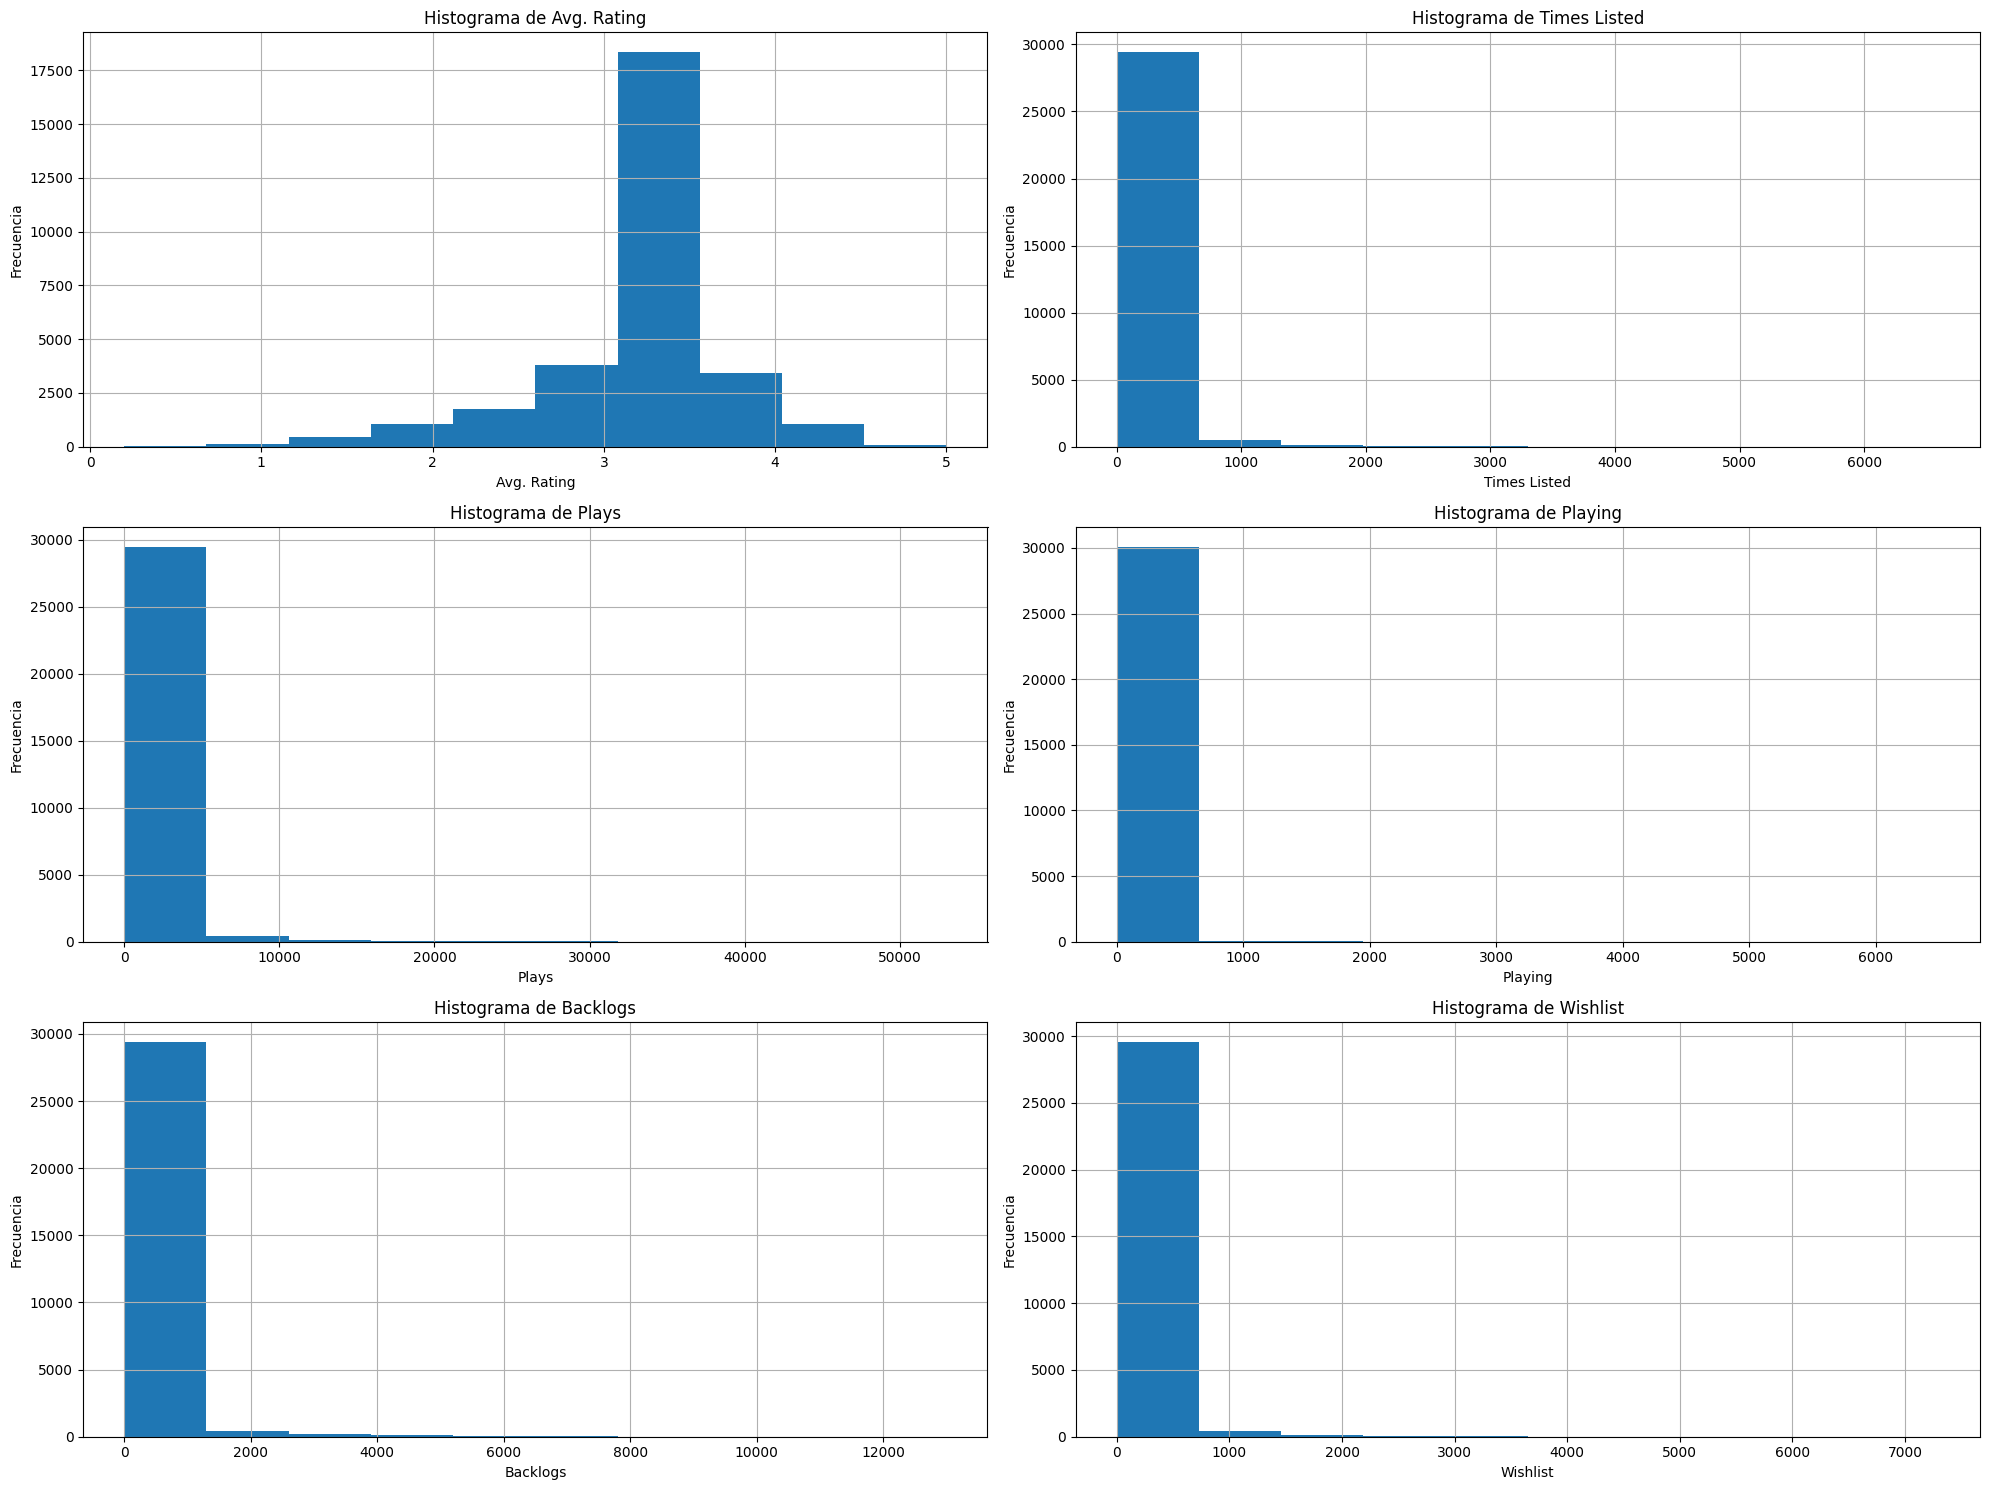

In [120]:
Funciones.plot_histograms(df, columnas_numericas)

In [ ]:
'''
En este caso no es útil la función de densidad de probabilidad:
-sE SUELE UTLIZAR PARA NUMÉRICAS CONTINUAS Y ADEMÁS:
Las variables numéricas de este dataset tienen una cantidad significativa de valores concentrados en los extremos (sobretodo cerca de cero). 
Estos valores atípicos tienen una distribución muy sesgada, lo que provoca que la visualización del histograma no sea efectiva
'''

<a id="Variables-Numericas-Conclusiones-finales"></a>
## Variables Numericas: Conclusiones finales



### Conclusiones del Análisis Univariante de Variables Numéricas

#### 1. Medidas Posicionales y Distribución

Con el objetivo de conocer la distribución de los datos e identificar los valores atípicos en las variables categóricas, he usado el **IQR** y los **Boxplots.**

En líneas generales se puede observar las siguientes características en el conjunto de variables:

-  La caja central que representa el rango intercuartílico (IQR), que es la distancia entre el primer cuartil (Q1, el 25%) y el tercer cuartil (Q3, el 75%), es decir donde se encuentran el 50% de los datos es muy estrecha en todas las gráficas.
Esto me indica que el IQR es extremadamente estrecho, o dicho en otras palabras, que la mitad de los datos está muy agrupado. (Aunque sea muy extrecho no quiere decir que haya más valores fuera que dentro de la caja central)

-  Se pueden identificar muchos valores que se extienden fuera de los bigotes, lo que quiere decir que aunque la mitad de los valores se encuentran muy agrupado, existen muchos otros que tienen características completamente diferentes.
Exceptuando `Avg. Rating`, la mayoría de estos outliers se encuentran con una distribución sesgada hacia la derecha, es decir, tiene una cola más larga en el lado derecho del gráfico.

-  En este contexto, los resultados se pueden traducir en que el 50% de los juegos se encuentran cerca del cero por lo que significa que no son populares, mientras que la distribución de los outliers varía dependiendo según la variable categórica.
En algunos casos, los outliers tienen una distribución más dispersa mientras que en otros la concentración está más cerca de la caja central.

-  Como conclusión general, observo que más del 50% de los videjuegos muestran datos muy 'humildes' debido a que no son muy populares. Luego existe un grupo moderado de datos que son moderadamente conocidos y jugados.
Finalmente se observa un grupo mucho más reducido de videjuegos que son extremadamente populares, un clara representación del mercado: **Existen muchos videjuegos con características muy diferentes pero los que dominan el mercado son unos pocos**

**Análisis detallado por variable**

- **Release Date**:
  - **Mean**: La fecha promedio de lanzamiento de los juegos es el 12 de noviembre de 2011, sugiriendo una concentración de lanzamientos en la última década.

- **Avg. Rating**:
  - **IQR**: 0.2 - Indica una variabilidad moderada en las calificaciones.
  - **Boxplot**: Muestra una concentración de calificaciones alrededor de la media, con pocos valores atípicos.

- **Plays**:
  - **IQR**: 116.0 - Refleja una distribución muy sesgada.
  - **Boxplot**: Evidencia la presencia de varios valores atípicos, indicando juegos extremadamente populares.

- **Playing (Actualmente Jugando)**:
  - **IQR**: 2.0 - Alta dispersión en la cantidad de jugadores actuales.
  - **Boxplot**: Muestra una variabilidad significativa, con algunos juegos atrayendo muchos más jugadores.

- **Backlogs (Pendientes)**:
  - **IQR**: 42.0 - Gran variabilidad en la cantidad de juegos pendientes.
  - **Boxplot**: Refleja los diferentes intereses y preferencias de los jugadores.

- **Wishlist (Lista de Deseos)**:
  - **IQR**: 21.0 - Variabilidad considerable en la cantidad de veces que los juegos aparecen en listas de deseos.
  - **Boxplot**: Indica diferentes niveles de anticipación por parte de los jugadores.

#### 2. Desviación y Variabilidad

Para profundizar en el entendimiento de la naturaleza de las variables numéricas, he complementado el análisis con herramientas estadísticas adicionales:

-  La desviación estándar (std) y la media (mean) para obtener una visión clara de la tendencia central y la dispersión de los datos

-  Coeficiente de variación (CV), que proporciona una medida para conocer la dispersión relativa, facilitando la comparación entre variables de diferentes escalas. 

-  Histogramas,  para visualizar la distribución de frecuencias de los datos.

-  En líneas generales se puede observar las siguientes características en el conjunto de variables:

  -  Las medidas de desviación estándar y coeficiente de variación nos muestran un panorama bastante homogeneo en general. Mientras que la calificación promedio (`Avg. Rating`) presenta una variabilidad moderada y una dispersión relativamente baja, lo que indica cierta consistencia en las opiniones de los usuarios, otras variables como `Times Listed`, `Plays`, `Playing`, `Backlogs` y `Wishlist` exhiben una alta hasta extremadamente alta variabilidad y dispersión. Esto sugiere que, aunque hay un patrón de consistencia en las calificaciones, hay enormes diferencias en cómo se juega, se desea, o se lista cada juego.

  -  La alta desviación estándar y los elevados coeficientes de variación en la mayoría de las variables indican que hay una pequeña cantidad de juegos que significativamente se desvían del promedio, en términos de popularidad. Esto se refleja en la presencia de valores atípicos muy alejados de la mediana, sugiriendo que unos pocos títulos dominan en términos de jugabilidad, listas de deseos, o pendientes.

  -  Debido a las características que presentan estas variables, considero que que, exceptuando `Avg. Rating`, no tiene sentido hacer uso de la media, ya que la gran cantidad de valores extremos haría que el resultado no sea representantivo del conjunto de datos


**Análisis detallado por variable**

- **Avg. Rating**:
  - **Std**: 0.531258 - Indica una variabilidad moderada en las calificaciones.
  - **CV**: 17.15% - Variabilidad relativamente baja.

- **Times Listed (Veces Listado)**:
  - **Std**: 260.565944 - Muestra una dispersión alta.
  - **CV**: 353.97% - Alta variabilidad relativa.

- **Plays**:
  - **Std**: 2238.989865 - Indica una dispersión extremadamente alta.
  - **CV**: 426.24% - Variabilidad extremadamente alta.

- **Playing (Actualmente Jugando)**:
  - **Std**: 119.980305 - Alta dispersión en la cantidad de jugadores.
  - **CV**: 717.29% - Variabilidad extremadamente alta.

- **Backlogs (Pendientes)**:
  - **Std**: 563.64268 - Muy alta variabilidad en los juegos pendientes.
  - **CV**: 395.54% - Alta variabilidad relativa.

- **Wishlist (Lista de Deseos)**:
  - **Std**: 294.548148 - Alta dispersión en las listas de deseos.
  - **CV**: 425.08% - Alta variabilidad relativa.



<a id="Tratamiento-de-Outliers"></a>
## Tratamiento de Outliers

He realizado un análisis exaustivo de las variables del dataset además de la propia naturaleza del mismo. Mi enfoque al analizar el dataset de unos 30,000 títulos (tras rslizar las limpiezas pertinentes) es comprender el mercado en su totalidad, incluyendo tanto los éxitos rotundos como los juegos menos conocidos. He decidido no eliminar los outliers de mi análisis por varias razones fundamentales, que se apoyan principalmente en la naturaleza del dataset y de la industria de los videojuegos.

#### **Reflejo de la Realidad del Dataset y Mercado**

Los outliers en mi dataset no son solo desviaciones estadísticas; representan fenómenos reales y significativos en la industria del juego, es decir no son causa de ningún error a la hora de recopliar la información o de realizar la limpieza, sino que son el reflejo propio de la realidad de este 'mundillo'.

Los títulos con números extremadamente altos de jugadores, listados o ventas reflejan éxitos masivos que han impactado profundamente en la cultura y las tendencias de consumo. Eliminar estos puntos de datos podría ocultar patrones clave y lecciones valiosas sobre lo que hace que un juego sea exitoso. La comprensión de estos éxitos es esencial, especialmente al considerar la evolución del mercado y la identificación de oportunidades para futuros desarrollos de juegos, y en definitiva, para poder responder a las preguntas que yo mismo me he planteado para tratar de tener una visión clara sobre este sector.

#### **Valor de los Datos Extremos**

En mi análisis, los valores extremos proporcionan insights críticos que pueden influir en la estrategia de producto tanto para una startup como para una compañía consolidada. Por ejemplo, al identificar juegos con altos números en 'Wishlist' o 'Backlogs', puedo obtener una comprensión más rica de las tendencias actuales y las preferencias de los jugadores, información que sería diluida si se eliminan los outliers.

#### **Impacto en las Medidas de Tendencia Central**

Soy consciente de que mantener los outliers afectará las medidas de tendencia central; especialmente la media. Sin embargo, en este contexto, la mediana y los percentiles ofrecen alternativas más robustas para entender la distribución central de los datos.


In [122]:
df.to_csv('data/backloggd_dataset_limpio_dos.csv', index=False)

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30208 entries, 0 to 30207
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Title         30208 non-null  object        
 1   Release Date  30208 non-null  datetime64[ns]
 2   Team          30208 non-null  object        
 3   Avg. Rating   30208 non-null  float64       
 4   Times Listed  30208 non-null  int64         
 5   Genres        30208 non-null  object        
 6   Summary       30208 non-null  object        
 7   Reviews       30208 non-null  object        
 8   Platforms     30208 non-null  object        
 9   Plays         30208 non-null  int64         
 10  Playing       30208 non-null  int64         
 11  Backlogs      30208 non-null  int64         
 12  Wishlist      30208 non-null  int64         
 13  GameID        30208 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(6)
memory usage: 3.2+ MB


<a id="Filtrados-y-manipulaciones-del-Data-Frame"></a>
## Filtrados y manipulaciones del Data Frame

In [70]:
nombre_del_juego = "Fortnite"
fila_del_juego = df[df['Title'] == nombre_del_juego]
fila_del_juego

,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist,GameID
57,Fortnite,2017-07-25,[Epic Games],2.9,1400,"[Adventure, RPG, Shooter, Strategy]",Fortnite is the completely free online game wh...,"['👎', 'Best multiplayer game', ""Very unfun gam...","[Windows PC, Android, Mac, PlayStation 4, iOS,...",29000,1800,772,66,57


¿Cuáles son los 5 videojuegos más populares en términos de veces?  muestra también los 5 más jugados por cada década

In [69]:
# Para descubrir los videjuegos más populares, me voy a centrar el la variable 'Plays', para determinar cuáles han sido los videjuegos más jugados
# Primero voy a centrarme en sacar un top 10, sin tener en cuenta ninguna característica más

# Los videojuegos con el mayor número de 'Plays'
# Para ello, filtro de forma descendente con sort_values en la columna 'Plays'
top_plays = df.sort_values('Plays', ascending=False).head(10)
top_plays

,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist,GameID
7,Minecraft,2011-11-18,[Mojang Studios],4.3,3500,"[Adventure, Simulator]",Minecraft focuses on allowing the player to ex...,"[""This game and everyone who played it on YouT...","[Windows PC, Mac, Linux]",53000,3100,1800,323,7
22,Grand Theft Auto V,2013-09-17,"[Rockstar North, Rockstar Games]",3.9,3400,"[Adventure, Racing, Shooter]",Grand Theft Auto V is a vast open world game s...,"['👍', 'my first finished GTA', 'For the longes...","[Windows PC, Xbox 360, PlayStation 4, PlayStat...",49000,1400,5400,1100,22
2,The Legend of Zelda: Breath of the Wild,2017-03-03,"[Nintendo EPD Production Group No. 3, Nintendo]",4.4,6600,"[Adventure, Puzzle, RPG]",The Legend of Zelda: Breath of the Wild is the...,"['👍', 'very nice game, my first Legend of Zeld...","[Wii U, Nintendo Switch]",48000,3700,7600,3900,2
11,Portal 2,2011-04-18,"[Electronic Arts, Valve]",4.4,4500,"[Adventure, Platform, Puzzle, Shooter]","Sequel to the acclaimed Portal (2007), Portal ...",['An amazing improvement on an already great g...,"[Windows PC, Mac, Xbox 360, Linux, PlayStation...",46000,826,7200,1900,11
23,Portal,2007-10-10,"[Electronic Arts, Valve]",4.1,3200,"[Platform, Puzzle, Shooter]","Waking up in a seemingly empty laboratory, the...","['I really like this game, it was a fun and cr...","[Windows PC, Android, Mac, Xbox 360, Linux, Pl...",44000,444,4900,1700,23
5,Undertale,2015-09-15,"[tobyfox, 8-4]",4.3,5100,"[Adventure, Indie, RPG, Turn Based Strategy]","A small child falls into the Underground, wher...","[""I can't explain how much I love this game. T...","[Windows PC, Mac, Linux, PlayStation 4, Xbox O...",43000,984,8200,2900,5
24,Super Mario Odyssey,2017-10-27,[Nintendo],4.2,4500,"[Adventure, Platform]",Explore incredible places far from the Mushroo...,['I had so much fun playing this 😭😭😭 I hope th...,[Nintendo Switch],39000,1100,5000,3100,24
20,Among Us,2018-06-15,[Innersloth],3.0,1300,"[Indie, Strategy]",Play with 4-15 player online or via local WiFi...,"['This game is silly and has lots of memes, bu...","[Windows PC, Android, PlayStation 4, iOS, Xbox...",39000,581,1200,166,20
37,Super Smash Bros. Ultimate,2018-12-07,"[Bandai Namco Studios, Nintendo]",4.1,3700,"[Fighting, Platform]",Legendary game worlds and fighters collide in ...,['The best game in the Smash Bros. series IMO!...,[Nintendo Switch],38000,1600,1800,1200,37
15,God of War,2018-04-20,"[Sony Interactive Entertainment, SIE Santa Mon...",4.2,4400,"[Adventure, Brawler, RPG]",God of War is the sequel to God of War III as ...,['Although I would generally say that I enjoye...,"[Windows PC, PlayStation 4]",35000,1500,7900,4000,15


In [68]:

# Agrupar los juegos por década y obtener los 5 juegos más jugados por cada década
# Luego, ordenar los resultados por fecha de lanzamiento de menor a mayor
top_5_per_decade_sorted = df.groupby(
    # La siguiente línea calcula la década para cada juego. Se divide el año de lanzamiento por 10,
    # se convierte a entero (lo que elimina los decimales) y luego se multiplica por 10 para obtener
    # el año inicial de la década (por ejemplo, 1992 se convierte en 1990)
    (df['Release Date'].dt.year // 10) * 10
).apply(
    # Dentro de cada grupo (década), selecciona los 5 juegos con más 'Plays'.
    # 'nlargest' realiza esta selección, ordenando los juegos por la columna 'Plays' de mayor a menor
    # y eligiendo los primeros 5.
    lambda x: x.nlargest(5, 'Plays')
).reset_index(
    # 'reset_index' con 'drop=True' elimina el índice jerárquico creado por 'groupby' y 'apply',
    # y lo reemplaza por un índice simple, que es más fácil de manejar.
    drop=True
).sort_values(
    # Finalmente, ordena los juegos seleccionados por la columna 'Release Date' en orden ascendente
    # (de menor a mayor), lo que significa que los juegos más antiguos aparecerán primero.
    by='Release Date'
)

# Mostrar el DataFrame resultante
top_5_per_decade_sorted



,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist,GameID
0,Table Tennis,1969-07-01,[Magnavox],3.1,15,"[Arcade, Sport]",Table Tennis was developed from 1966-1969 unti...,"['mas old que el pong', ""Honestly I'm not sure...","[Odyssey, Analogue electronics]",24,1,5,4,13763
1,Space Travel,1969-12-31,[],3.1,7,[Simulator],Space Travel was an early computer game for Un...,['Minha tentativa de emular esse software não ...,[PDP-7],9,0,5,7,10599
6,The Oregon Trail,1971-12-03,[MECC],3.2,125,"[Adventure, Simulator, Strategy]",The Oregon Trail is a computer game originally...,"[""I hated playing it doesn't mean it's a bad g...","[HP 2100, CDC Cyber 70]",573,2,51,53,8529
2,Pong,1972-11-29,"[Fairchild Semiconductor, Atari, Inc.]",3.0,251,"[Arcade, Simulator, Sport]",Pong is a tennis game with simple two-dimensio...,"[""It's kind of like an ADHD fidget toy."", ""Thi...","[Arcade, Atari 2600]",3600,1,71,31,1504
3,Space Invaders,1978-06-01,"[Polyvox, Taito Corporation]",3.1,339,"[Arcade, Shooter]",Space Invaders is an arcade video game develop...,"[""Even if\n \n ...","[iOS, Arcade, Mobile]",2600,4,80,39,2509
5,Galaxian,1979-09-15,"[Namco, Polyvox]",2.8,174,"[Arcade, Shooter]",Galaxian is a shooter arcade game developed by...,"[""Galaxian is a simple game that does what it...",[Arcade],791,0,44,24,3278
4,Asteroids,1979-11-17,"[Atari, Inc., Accolade]",3.0,184,"[Arcade, Shooter]",Asteroids is an arcade space shooter released ...,"['Difendiamo la Terra dagli stronzoidi', 'The ...","[Arcade, Atari 8-bit, Apple II]",1100,2,36,17,3145
7,Super Mario Bros.,1985-09-13,"[Playtronic, Nintendo R&D4]",3.5,2400,"[Adventure, Platform]",A side scrolling 2D platformer and first entry...,"[""Can't exactly say this game holds very well,...","[Wii U, Arcade, Wii, Family Computer Disk Syst...",26000,104,1200,344,91
9,The Legend of Zelda,1986-02-21,"[Playtronic, Nintendo EAD]",3.2,1900,[Adventure],The Legend of Zelda is the first title in the ...,"[""I find that when people play the original Le...","[Wii U, Wii, Family Computer Disk System, Nint...",14000,204,2300,683,282
11,Super Mario Bros. 2,1988-10-09,"[Playtronic, Nintendo EAD]",3.1,1300,"[Adventure, Platform]","Super Mario Bros. 2, 2D platformer and sequel ...","[""I think this game is god awful, I have never...","[Wii U, Arcade, Wii, Nintendo 3DS, NES, Family...",12000,65,1200,300,416


### Los juegos más populares de los años 1970 fueron:
- **Pong** (Fecha de lanzamiento: 1972-11-29, Plays: 3600)
- **Space Invaders** (Fecha de lanzamiento: 1978-06-01, Plays: 2600)
- **Asteroids** (Fecha de lanzamiento: 1979-11-17, Plays: 1100)
- **Galaxian** (Fecha de lanzamiento: 1979-09-15, Plays: 791)
- **The Oregon Trail** (Fecha de lanzamiento: 1971-12-03, Plays: 573)

### Los juegos más populares de los años 1980 fueron:
- **Super Mario Bros.** (Fecha de lanzamiento: 1985-09-13, Plays: 26000)
- **Super Mario Bros. 3** (Fecha de lanzamiento: 1988-10-23, Plays: 21000)
- **The Legend of Zelda** (Fecha de lanzamiento: 1986-02-21, Plays: 14000)
- **Tetris** (Fecha de lanzamiento: 1989-11-01, Plays: 13000)
- **Super Mario Bros. 2** (Fecha de lanzamiento: 1988-10-09, Plays: 12000)

### Los juegos más populares de los años 1990 fueron:
- **Super Mario 64** (Fecha de lanzamiento: 1996-06-23, Plays: 31000)
- **The Legend of Zelda: Ocarina of Time** (Fecha de lanzamiento: 1998-11-21, Plays: 26000)
- **Super Mario World** (Fecha de lanzamiento: 1990-11-21, Plays: 26000)
- **Final Fantasy VII** (Fecha de lanzamiento: 1997-01-31, Plays: 20000)
- **Half-Life** (Fecha de lanzamiento: 1998-11-19, Plays: 20000)

### Los juegos más populares de los años 2000 fueron:
- **Portal** (Fecha de lanzamiento: 2007-10-10, Plays: 44000)
- **Super Mario Galaxy** (Fecha de lanzamiento: 2007-11-01, Plays: 31000)
- **Left 4 Dead 2** (Fecha de lanzamiento: 2009-11-17, Plays: 30000)
- **Grand Theft Auto: San Andreas** (Fecha de lanzamiento: 2004-10-26, Plays: 29000)
- **Super Smash Bros. Brawl** (Fecha de lanzamiento: 2008-01-31, Plays: 28000)

### Los juegos más populares de los años 2010 fueron:
- **Minecraft** (Fecha de lanzamiento: 2011-11-18, Plays: 53000)
- **Grand Theft Auto V** (Fecha de lanzamiento: 2013-09-17, Plays: 49000)
- **The Legend of Zelda: Breath of the Wild** (Fecha de lanzamiento: 2017-03-03, Plays: 48000)
- **Portal 2** (Fecha de lanzamiento: 2011-04-18, Plays: 46000)
- **Undertale** (Fecha de lanzamiento: 2015-09-15, Plays: 43000)

### Los juegos más populares de los años 2020 fueron:
- **Elden Ring** (Fecha de lanzamiento: 2022-02-25, Plays: 33000)
- **Animal Crossing: New Horizons** (Fecha de lanzamiento: 2020-03-19, Plays: 30000)
- **Fall Guys** (Fecha de lanzamiento: 2020-08-04, Plays: 26000)
- **Cyberpunk 2077** (Fecha de lanzamiento: 2020-12-09, Plays: 24000)
- **Genshin Impact** (Fecha de lanzamiento: 2020-09-28, Plays: 22000)


In [ ]:
nombre_del_juego = "Fortnite"
fila_del_juego = df[df['Title'] == nombre_del_juego]
fila_del_juego

Analizar éxito en sagas de videjuegos mediante filtrados

In [78]:
# Filtrar el DataFrame para mostrar solo las filas donde el título contenga los valores que yo quiera
filtered_df = df[df['Title'].str.contains("Grand Theft", na=False)]
sorted_df = filtered_df.sort_values(by='Plays', ascending=False) # ordeno por visualizaciones
sorted_df.head(10)


,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist,GameID
22,Grand Theft Auto V,2013-09-17,"[Rockstar North, Rockstar Games]",3.9,3400,"[Adventure, Racing, Shooter]",Grand Theft Auto V is a vast open world game s...,"['👍', 'my first finished GTA', 'For the longes...","[Windows PC, Xbox 360, PlayStation 4, PlayStat...",49000,1400,5400,1100,22
96,Grand Theft Auto: San Andreas,2004-10-26,"[TransGaming Inc., Rockstar Games]",4.1,2500,"[Adventure, Racing, Shooter]",Returning after his mother's murder to the sem...,"[""I have long history with this game. It was m...","[Windows PC, Android, Mac, Xbox, Xbox 360, Pla...",29000,434,3900,1200,96
161,Grand Theft Auto IV,2008-04-29,"[Rockstar North, Rockstar Games]",3.8,1800,"[Adventure, Racing, Shooter]",Grand Theft Auto IV is an action-adventure vid...,['Niko Bellic:\n \n ...,"[Windows PC, Xbox 360, PlayStation 3]",23000,516,3500,1300,161
263,Grand Theft Auto: Vice City,2002-10-27,"[TransGaming Inc., Rockstar Games]",3.8,1600,"[Adventure, Arcade, Racing, Shooter]","In the year 1986, Tommy Vercetti is heavily in...","['Games', 'i hated the fact that i couldnt swi...","[Windows PC, Mac, Xbox, PlayStation 2]",18000,179,2700,874,263
417,Grand Theft Auto III,2001-10-22,"[TransGaming Inc., Take-Two Interactive]",3.3,1100,"[Adventure, Racing, Shooter, Simulator]","Featuring a fully 3-D living city, a combinati...","['Devil May Cry 1 core', 'Some of the missions...","[Windows PC, Mac, Xbox, PlayStation 4, PlaySta...",12000,158,2100,632,417
1492,Grand Theft Auto: Chinatown Wars,2009-03-17,"[Rockstar Games, Rockstar North]",3.2,396,"[Adventure, Shooter]",Grand Theft Auto: Chinatown Wars is an entirel...,"['Un classique', 'Port on PS Vita.', 'Played t...","[Android, iOS, Nintendo DS, PlayStation Portable]",3600,48,715,319,1492
1578,Grand Theft Auto: Liberty City Stories,2005-10-25,"[Rockstar Leeds, Take-Two Interactive]",3.2,398,"[Adventure, Racing]",There are a million stories in Liberty City. T...,"[""Sur PSP c'était un Must have et en plus il é...","[Android, iOS, PlayStation 2, PlayStation Port...",3600,52,631,269,1578
1637,Grand Theft Auto: Vice City Stories,2006-10-31,"[Rockstar Leeds, Rockstar Games]",3.4,361,"[Adventure, Racing]",The PlayStation Portable follow-up to Rockstar...,"['The story is pretty good but , This is The W...","[PlayStation 2, PlayStation Portable]",3500,50,647,288,1637
1640,Grand Theft Auto IV: The Ballad of Gay Tony,2009-10-29,"[Take-Two Interactive, Rockstar Toronto]",3.9,259,"[Adventure, Racing, Shooter]",Grand Theft Auto: The Ballad of Gay Tony is th...,"[""It's more fun than TLAD, for sure. Although ...","[Windows PC, Xbox 360, PlayStation 3]",3300,37,536,175,1640
1800,Grand Theft Auto IV: The Lost and Damned,2009-02-17,"[Rockstar North, Rockstar Games]",3.4,234,"[Adventure, Racing, Shooter]",Grand Theft Auto IV: The Lost and Damned is th...,['Tout ca pour crever comme un con dans Gta 5'...,"[Windows PC, Xbox 360, PlayStation 3]",3200,40,476,147,1800


In [84]:
filtered_df_dos = df[df['Title'].str.contains("Resident", na=False)]
sorted_df_dos = filtered_df_dos.sort_values(by='Plays', ascending=False)
sorted_df_dos.head()

,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist,GameID
34,Resident Evil 2,2019-01-25,"[Capcom Development Division 1, Capcom]",4.3,4200,"[Adventure, Shooter]",Resident Evil 2 is a remake of 1998's Resident...,"['ne desem bilmiyorum valla çok güzeldi', 'yes...","[Windows PC, PlayStation 4, Xbox One, PlayStat...",27000,1000,6200,2900,34
85,Resident Evil 7: Biohazard,2017-01-24,[Capcom],3.9,2900,"[Adventure, Puzzle, Shooter]",Resident Evil 7: Biohazard is the first game o...,"[""It's okay I guess. Never find myself coming ...","[Windows PC, PlayStation 4, PlayStation VR, Xb...",22000,507,5200,2100,85
71,Resident Evil 4,2005-01-11,"[Capcom Production Studio 4, Capcom]",4.4,3200,[Shooter],Resident Evil 4 is the sixth installment of th...,"[""One of the best Resident Evil games, althoug...",[Nintendo GameCube],20000,464,4000,1600,71
61,Resident Evil Village,2021-05-06,[Capcom],3.9,2800,"[Adventure, Shooter]",Resident Evil Village is a first person surviv...,"[""The Franchise has gone off the rails, but th...","[Windows PC, Mac, PlayStation 4, iOS, Xbox One...",17000,518,5000,4100,61
215,Resident Evil 5,2009-03-05,[Capcom],3.2,1700,"[Adventure, Shooter]",Resident Evil 5 is the seventh video game in t...,['SHEVA! COME ON! COME ON! SHEVA! HURRY! HURRY...,"[Windows PC, Xbox 360, PlayStation 3]",16000,305,2800,875,215


In [83]:
filtered_df_tres = df[df['Title'].str.contains("Mario", na=False)]
sorted_df_tres = filtered_df_tres.sort_values(by='Plays', ascending=False)
sorted_df_tres.head(15)

,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist,GameID
24,Super Mario Odyssey,2017-10-27,[Nintendo],4.2,4500,"[Adventure, Platform]",Explore incredible places far from the Mushroo...,['I had so much fun playing this 😭😭😭 I hope th...,[Nintendo Switch],39000,1100,5000,3100,24
36,Super Mario 64,1996-06-23,"[Playtronic, Nintendo EAD]",4.1,3800,"[Adventure, Platform]",The first three dimensional entry in the Mario...,"['👍', 'Amazing for its time', ""I've sunk more ...","[Wii U, Wii, Nintendo 64]",31000,646,4100,1200,36
47,Super Mario Galaxy,2007-11-01,"[Nintendo, Nintendo EAD]",4.3,4000,"[Adventure, Platform]",A 3D platformer and first Wii entry in the Sup...,['my childhood. my adulthood. it will be my el...,[Wii],31000,675,5000,1800,47
89,Mario Kart 8 Deluxe,2017-04-28,"[Nintendo, Nintendo EPD]",4.1,2400,"[Arcade, Racing]",Hit the road with the definitive version of Ma...,['I can’t give iterations higher scores than t...,[Nintendo Switch],31000,1200,1300,912,89
165,Mario Kart Wii,2008-04-10,"[Nintendo, Nintendo EAD]",3.9,1700,[Racing],Mario Kart Wii is a multiplayer-oriented racin...,['countless memories with this one like many o...,[Wii],28000,142,766,232,165
82,Super Mario World,1990-11-21,"[Nintendo EAD, Nintendo]",4.2,3200,"[Adventure, Platform]",A 2D platformer and first entry on the SNES in...,"['The Best Snes Game Peak Mario Game', 'o melh...","[Wii U, Super Famicom, Arcade, SNES, Wii, New ...",26000,322,2700,706,82
91,Super Mario Bros.,1985-09-13,"[Playtronic, Nintendo R&D4]",3.5,2400,"[Adventure, Platform]",A side scrolling 2D platformer and first entry...,"[""Can't exactly say this game holds very well,...","[Wii U, Arcade, Wii, Family Computer Disk Syst...",26000,104,1200,344,91
172,New Super Mario Bros.,2006-05-15,"[iQue, Nintendo]",3.6,1600,"[Adventure, Platform]",New Super Mario Bros. is a side-scrolling 2.5D...,['This is a 4 stars for the mario mini games a...,"[Wii U, Nintendo DS]",24000,160,1400,461,172
259,Mario Kart DS,2005-11-14,[Nintendo EAD Software Development Group No.1],3.8,1400,[Racing],Mario Kart DS is the continuation of the long ...,"[""The racing feels very fun but it lacks the c...","[Wii U, Nintendo DS]",22000,67,697,240,259
152,Super Mario Bros. 3,1988-10-23,"[Playtronic, Nintendo R&D4]",4.1,2400,[Platform],"Super Mario Bros. 3, the third entry in the Su...","[""First GOTM finished for December 2023. While...","[Wii U, Arcade, Wii, Nintendo 3DS, NES, Family...",21000,173,2200,569,152


In [131]:
filtered_df_cuatro = df[df['Title'].str.contains("Spider", na=False)]
sorted_df_cuatro = filtered_df_cuatro.sort_values(by='Plays', ascending=False)
sorted_df_cuatro.head(15)

,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist,GameID
26,Marvel's Spider-Man,2018-09-07,"[Sony Interactive Entertainment, Insomniac Games]",4.1,3700,"[Adventure, Brawler]","Starring the world’s most iconic Super Hero, S...",['this game\n \n ...,[PlayStation 4],35000,955,4600,3300,26
48,Marvel's Spider-Man: Miles Morales,2020-11-12,"[Insomniac Games, Sony Interactive Entertainment]",3.8,2700,"[Adventure, Brawler]",The latest adventure in the Spider-Man univers...,['story is ok but the gameplay is an insane up...,"[Windows PC, PlayStation 4, PlayStation 5]",20000,714,4700,4200,48
794,Spider-Man 2,2004-06-28,"[Taito, Treyarch]",3.6,686,"[Adventure, Brawler]","In Spider-Man 2, Manhattan becomes a gamer's p...",['game boy version. 3D exploration in that gam...,"[Nintendo GameCube, Xbox, PlayStation 2]",8600,56,806,433,794
281,Marvel's Spider-Man Remastered,2020-11-12,"[Sony Interactive Entertainment, Insomniac Games]",4.2,772,"[Adventure, Brawler]",Included in the Ultimate Edition of Marvel's S...,['pretty awesome i lov e swinging around and b...,"[Windows PC, PlayStation 5]",7600,448,1400,1000,281
58,Marvel's Spider-Man 2,2023-10-20,"[Sony Interactive Entertainment, Insomniac Games]",4.3,1900,"[Adventure, Brawler]",Marvel's Spider-Man 2 is the next game in the ...,"['Platinum-d', ""It's a perfectly safe sequel t...",[PlayStation 5],5600,685,2100,4800,58
971,Spider-Man,2000-08-30,"[Gradiente, Westlake Interactive]",3.5,571,"[Adventure, Brawler]",YOU DON'T JUST PLAY IT... YOU LIVE IT\n ...,['Топ игра по ЧП. Получить удовольствие можно ...,"[Windows PC, Mac, PlayStation, Nintendo 64, Dr...",5600,29,582,335,971
1051,Ultimate Spider-Man,2005-09-21,"[Activision, Beenox]",3.7,517,[Brawler],"Based on the comic book of the same name, Ulti...",['Гонка по Человеку-пауку. Полный кал. Разрабо...,"[Windows PC, Nintendo GameCube, Xbox, PlayStat...",5400,42,698,461,1051
1843,Spider-Man 3,2007-05-04,"[Activision, Treyarch]",2.6,325,[Platform],"The next-gen version of Spider-Man 3, a videog...","['pq eu perdi meu tempo com isso?', ""It's not ...","[Windows PC, Xbox 360, PlayStation 3]",4700,21,305,173,1843
1623,Spider-Man,2002-04-15,"[Treyarch, Activision]",2.8,340,"[Adventure, Platform]",Spider-Man is an action-adventure game release...,['combos were too hard for me as a kid D: gott...,"[Windows PC, Nintendo GameCube, Xbox, PlayStat...",4400,21,368,149,1623
1270,Spider-Man: Shattered Dimensions,2010-09-07,"[Beenox, Activision]",3.5,374,"[Adventure, Platform]",Spider-Man: Shattered Dimensions blends togeth...,"['zzzzzzzzzz', 'Spiderverse concept is perfect...","[Windows PC, Xbox 360, PlayStation 3]",3800,39,617,531,1270


In [133]:
filtered_df_cinco = df[df['Title'].str.contains("Zelda", na=False)]
sorted_df_cinco = filtered_df_cinco.sort_values(by='Plays', ascending=False)
sorted_df_cinco.head(15)

,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist,GameID
2,The Legend of Zelda: Breath of the Wild,2017-03-03,"[Nintendo EPD Production Group No. 3, Nintendo]",4.4,6600,"[Adventure, Puzzle, RPG]",The Legend of Zelda: Breath of the Wild is the...,"['👍', 'very nice game, my first Legend of Zeld...","[Wii U, Nintendo Switch]",48000,3700,7600,3900,2
63,The Legend of Zelda: Ocarina of Time,1998-11-21,"[iQue, Nintendo EAD]",4.3,3500,"[Adventure, RPG]",The Legend of Zelda: Ocarina of Time is the fi...,['“cinema fr”\n \n ...,"[Wii U, Wii, Nintendo 64]",26000,725,5100,2100,63
92,The Legend of Zelda: Majora's Mask,2000-04-27,"[Gradiente, Nintendo EAD]",4.4,3400,[Adventure],The Legend of Zelda: Majora's Mask is a direct...,"['depression simulator', ""I always say I love ...","[Wii U, Wii, Nintendo 64]",18000,500,6400,2800,92
143,The Legend of Zelda: A Link to the Past,1991-11-21,"[Hyundai, Nintendo EAD]",4.1,2600,"[Adventure, Puzzle]",The Legend of Zelda: A Link to the Past is a t...,"['fuck the worm', 'Man this game is amazing. G...","[Wii U, Super Famicom, SNES, Wii, New Nintendo...",18000,541,5100,1400,143
1,The Legend of Zelda: Tears of the Kingdom,2023-05-12,"[Nintendo, Nintendo EPD Production Group No. 3]",4.5,4200,"[Adventure, RPG]",The Legend of Zelda: Tears of the Kingdom is t...,['Legend of Zelda: Tears of the Kingdom is a v...,[Nintendo Switch],16000,6500,6300,6900,1
210,The Legend of Zelda: The Wind Waker,2002-12-13,"[Nintendo EAD Software Development Group No.3,...",4.3,2400,"[Adventure, Puzzle, RPG]",The Legend of Zelda: The Wind Waker is the fir...,"['My favorite game of all time!', 'better than...",[Nintendo GameCube],16000,351,4400,2100,210
252,The Legend of Zelda: Ocarina of Time 3D,2011-06-16,"[Grezzo, Nintendo]",4.3,1600,"[Adventure, Puzzle, RPG]",The Legend of Zelda: Ocarina of Time 3D is a r...,"['my first 3d zelda. love this game to death',...",[Nintendo 3DS],16000,505,3000,931,252
231,The Legend of Zelda: Twilight Princess,2006-11-19,"[Nintendo, Nintendo EAD Software Development G...",4.1,1400,"[Adventure, Puzzle, RPG]",The Legend of Zelda: Twilight Princess is the ...,"[""The peak of traditional Zelda. I don't know ...",[Nintendo GameCube],15000,346,4200,2000,231
272,The Legend of Zelda: A Link Between Worlds,2013-11-22,"[Nintendo, Nintendo EAD Software Development G...",4.1,2000,"[Adventure, Puzzle, RPG]",The Legend of Zelda: A Link Between Worlds is ...,"[""As far as 'traditional' Zelda games go, this...",[Nintendo 3DS],14000,229,4000,1700,272
282,The Legend of Zelda,1986-02-21,"[Playtronic, Nintendo EAD]",3.2,1900,[Adventure],The Legend of Zelda is the first title in the ...,"[""I find that when people play the original Le...","[Wii U, Wii, Family Computer Disk System, Nint...",14000,204,2300,683,282


In [143]:
# Juegos Indie más populares

# Filtrar para obtener solo juegos del género 'Indie'
indie_games = df_exploded_genres[df_exploded_genres['Genres'].str.contains("Indie", na=False)]

# Ordenar los juegos 'Indie' por 'Plays' de mayor a menor
sorted_indie_games = indie_games.sort_values(by='Plays', ascending=False)

# Utilizar .head() para mostrar las primeras filas (por ejemplo, las 5 primeras)
sorted_indie_games.head(10)


,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist,GameID
5,Undertale,2015-09-15,"[tobyfox, 8-4]",4.3,5100,Indie,"A small child falls into the Underground, wher...","[""I can't explain how much I love this game. T...","[Windows PC, Mac, Linux, PlayStation 4, Xbox O...",43000,984,8200,2900,5
20,Among Us,2018-06-15,[Innersloth],3.0,1300,Indie,Play with 4-15 player online or via local WiFi...,"['This game is silly and has lots of memes, bu...","[Windows PC, Android, PlayStation 4, iOS, Xbox...",39000,581,1200,166,20
3,Hades,2018-12-07,[Supergiant Games],4.3,4200,Indie,A rogue-lite hack and slash dungeon crawler in...,"[""I enjoyed it quite a bit, but with games lik...","[Windows PC, Mac, PlayStation 4, Xbox One, Pla...",35000,4400,10000,5300,3
4,Hollow Knight,2017-02-24,[Team Cherry],4.4,4600,Indie,A 2D metroidvania with an emphasis on close co...,"['This game is perfect, I immediately fell in ...","[Windows PC, Mac, Wii U, Linux, Nintendo Switch]",35000,3600,13000,3600,4
39,Stardew Valley,2016-02-26,"[ConcernedApe, Chucklefish Games]",4.1,2800,Indie,Stardew Valley is an open-ended country-life R...,"['10/10', '👍', ""Couldn't find any other game i...","[Windows PC, Android, Mac, Wii U, Linux, PlayS...",34000,3300,6200,1800,39
12,Celeste,2018-01-25,"[Maddy Makes Games, Extremely OK Games]",4.3,4300,Indie,Help Madeline survive her inner demons on her ...,['I didn’t expect to enjoy Celeste as much as ...,"[Windows PC, Mac, Linux, PlayStation 4, Xbox O...",32000,1900,9500,3000,12
72,Terraria,2011-05-16,"[505 Games, Re-Logic]",4.0,2000,Indie,"Dig, Fight, Explore, Build: The very world is ...","['Not gonna lie, better than minceraft.', 'BES...","[Windows PC, Android, Mac, Wii U, Xbox 360, Li...",30000,1200,3900,983,72
35,Cuphead,2017-09-29,[Studio MDHR],4.1,2800,Indie,Cuphead is a classic run and gun action game h...,"[""This is a very challenging and fun Indie gam...","[Windows PC, Mac, PlayStation 4, Xbox One, Nin...",29000,1700,7600,3900,35
90,Fall Guys,2020-08-04,"[Epic Games, Mediatonic]",3.0,1300,Indie,Fall Guys flings hordes of contestants togethe...,"['very repetitive, I used to be insane at the ...","[Windows PC, PlayStation 4, Xbox One, PlayStat...",26000,788,959,287,90
156,Rocket League,2015-07-06,[Psyonix],3.3,1400,Indie,Rocket League is a high-powered hybrid of arca...,"['en iyi oyunlardan biri', 'Supersonic-acrobat...","[Windows PC, Mac, Linux, PlayStation 4, Xbox O...",26000,942,1100,147,156


In [139]:
nombre_del_juego = "Among Us"
fila_del_juego = df[df['Title'] == nombre_del_juego]
fila_del_juego

,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist,GameID
20,Among Us,2018-06-15,[Innersloth],3.0,1300,"[Indie, Strategy]",Play with 4-15 player online or via local WiFi...,"['This game is silly and has lots of memes, bu...","[Windows PC, Android, PlayStation 4, iOS, Xbox...",39000,581,1200,166,20
22981,Among Us,2010-02-26,[],3.1,0,[Puzzle],A multiplayer game of fungal cannibalism that ...,['please make it stop'],[iOS],1,0,0,0,22981


In [146]:
# Juegos innersloth más populares

# Filtrar para obtener solo juegos del género 'innersloth'
innersloth_games = df_exploded_team[df_exploded_team['Team'].str.contains("Innersloth", na=False)]

# Ordenar los juegos 'innersloth' por 'Plays' de mayor a menor
sorted_innersloth_games = innersloth_games.sort_values(by='Plays', ascending=False)

# Utilizar .head() para mostrar las primeras filas (por ejemplo, las 5 primeras)
sorted_innersloth_games.head(10)

,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist,GameID
20,Among Us,2018-06-15,Innersloth,3.0,1300,"[Indie, Strategy]",Play with 4-15 player online or via local WiFi...,"['This game is silly and has lots of memes, bu...","[Windows PC, Android, PlayStation 4, iOS, Xbox...",39000,581,1200,166,20
1486,The Henry Stickmin Collection,2020-08-07,Innersloth,3.9,301,"[Adventure, Indie, Point-and-Click]",The Henry Stickmin Collection is a Newgrounds ...,"[""It's kinda genius in a weird way. I wish I h...","[Windows PC, Mac]",3000,42,379,265,1486
9689,HideNSeek,2020-05-01,Innersloth,3.1,0,"[Arcade, Strategy]",The HideNSeek Beta was a game demo by Innerslo...,[],"[Windows PC, Android]",1,0,1,0,9689


In [147]:
nombre_del_juego = "The Day Before"
fila_del_juego = df[df['Title'] == nombre_del_juego]
fila_del_juego

,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist,GameID
1768,The Day Before,2023-12-07,"[Fntastic, MyTona]",1.0,45,"[Adventure, Shooter]",The Day Before is an open-world MMO survival s...,['Ten Years from now a 17 year old from Wiscon...,"[Windows PC, PlayStation 5, Xbox Series]",43,2,37,133,1768


In [148]:
# Juegos fntastic más populares

# Filtrar para obtener solo juegos del género 'fntastic'
fntastic_games = df_exploded_team[df_exploded_team['Team'].str.contains("Fntastic", na=False)]

# Ordenar los juegos 'fntastic' por 'Plays' de mayor a menor
sorted_fntastic_games = fntastic_games.sort_values(by='Plays', ascending=False)

# Utilizar .head() para mostrar las primeras filas (por ejemplo, las 5 primeras)
sorted_fntastic_games.head(10)

,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist,GameID
6864,Propnight,2021-12-01,Fntastic,2.7,14,"[Adventure, RPG, Strategy]",Propnight is a 4vs1 multiplayer physics-based ...,"[""This game is super fun to play with friends,...",[Windows PC],112,6,23,16,6864
5862,The Wild Eight,2018-02-08,Fntastic,2.5,22,"[Adventure, Indie, RPG, Simulator]",The Wild Eight is an intense survival action-a...,"[""At first, the game is pretty good - you coll...","[Windows PC, PlayStation 4, Xbox One, Xbox Ser...",57,2,69,12,5862
1768,The Day Before,2023-12-07,Fntastic,1.0,45,"[Adventure, Shooter]",The Day Before is an open-world MMO survival s...,['Ten Years from now a 17 year old from Wiscon...,"[Windows PC, PlayStation 5, Xbox Series]",43,2,37,133,1768


filtered_df_tres = df[df['Title'].str.contains("Mario", na=False)]
sorted_df_tres = filtered_df_tres.sort_values(by='Plays', ascending=False)
sorted_df_tres.head(15)